# Load Modules

In [ ]:
from IPython.display import clear_output
import time

In [ ]:
! pip install pyxdf==1.16.0
! pip install mne
! pip install neurokit2
! pip install Pympler
! pip install ydata-profiling

! mkdir preprocessed_data
! mkdir features
! mkdir plots

clear_output(wait=True)
time.sleep(0.1)

print(f" ")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import yaml

import numpy as np

from tqdm import tqdm

import joblib
import importlib

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain

import pandas as pd
from ydata_profiling import ProfileReport

import sys
import gc
import tracemalloc

import math

In [ ]:
import pyxdf
import neurokit2 as nk

import functions as fnc
importlib.reload(fnc)

import sp as sp
importlib.reload(sp)

from functions import STIMULUS_FILENAME, XDF_DIR, TARGET_STREAM, STIMULUS_STREAMS, RESTING_STREAMS, MARKER_STREAMS, TARGET_EVENTS, LABELS, DURATIONS
from functions import PREPROCESSED_DIR, FEATURES_DIR, DATASET_DIR, CHILL_EVENTS_DIR, CHILLS_DATA_DIR, NON_CHILLS_DATA_DIR

In [ ]:
TIME_WINDOW = 6
CHILLS_REPORT_WINDOW = 3
PLOT_TIME_WINDOW = 15

phases = ['pre_rest', 'stimulus1', 'stimulus2', 'stimulus3', 'post_rest']
stimuli_phases = phases[1:-1]
rest_phases = ['pre_rest', 'post_rest']

# Preprocessing

In [ ]:
# @title preprocessing of data

subjects_info = fnc.subjects_info(STIMULUS_FILENAME)

subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]

# subjects = ["5082"]

subjects_preprocessed_data = dict()

for s, subject in enumerate(subjects):

  subject_path = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")

  if os.path.exists(os.path.join(subject_path))!=True:

    print(f"{s+1}/{len(subjects)}: {subject}")
    print(f"-------------------------------------------------------------------")

    # GET ORDER of STIMULUS PRESENTATION
    stimulus_order = fnc.get_stimulus_order(subject, subjects_info)
    if not stimulus_order:
        continue
    print(f"Stimulus Order for subject {subject}: {stimulus_order}")

    # LOAD XDF FILE
    xdf_file_path = os.path.join(XDF_DIR, f"{subject}.xdf")
    try:
        streams, _ = pyxdf.load_xdf(xdf_file_path)
        chills_timestamps = fnc.process_markers(streams, MARKER_STREAMS, TARGET_EVENTS)
    except FileNotFoundError:
        print(f"Error: The file {xdf_file_path}.xdf was not found.")
        continue
    except Exception as e:
        print(f"An error occurred while loading {xdf_file_path}.xdf: {e}")
        continue

    # GET STIMULUS/RESTING STATE ONSET
    stimulus_latencies = fnc.process_markers(streams, STIMULUS_STREAMS, TARGET_EVENTS)
    resting_latencies = fnc.process_markers(streams, RESTING_STREAMS, TARGET_EVENTS)
    print(f"Stimulus latencies: {stimulus_latencies}")
    print(f"Resting latencies: {resting_latencies}")
    for stream in STIMULUS_STREAMS:
        stimulus_latencies_ordered = {i: stimulus_latencies[stream][stimulus_order.index(i)] for i in
                                        stimulus_order}
    print(f"Stimulus Latencies: {stimulus_latencies_ordered}")

    # EXTRACT DATA
    data, stream = fnc.extract_raw_data(streams, TARGET_STREAM, LABELS)
    if data is None:
        continue

    # GET SAMPLING RATE
    timestamps = data["Timestamps"]
    effective_fs = sp.estimate_sampling_rate(timestamps)
    sampling_rate = int(np.round(effective_fs))
    print(f"Sampling Rate: {sampling_rate}")

    if 'desc' in stream['info'] and 'channels' in stream['info']['desc'][0]:
        channel_labels = stream['info']['desc'][0]['channels'][0]['channel']
        channel_names = [ch['label'][0] for ch in channel_labels]
        print("Channel names:", channel_names)

        concatenated_data = fnc.extract_and_concatenate_data(
            data, timestamps, sampling_rate, stimulus_latencies_ordered, resting_latencies, stimulus_order
        )

        preprocessed_data = dict()
        for epoch in concatenated_data["epochs"]:
          data = concatenated_data["epochs"][epoch]
          data["Timestamps"] = concatenated_data["timestamps"][epoch]
          output = sp.preprocess_data(data)
          preprocessed_data[epoch] = output
        preprocessed_data["chills"] = chills_timestamps

        if ~os.path.exists(subject_path):
          joblib.dump(preprocessed_data, subject_path)
          subjects_preprocessed_data[subject] = preprocessed_data

    clear_output(wait=True)
    time.sleep(0.1)

clear_output(wait=True)
time.sleep(0.1)
print(f"")

In [ ]:
# @title Check Subjects Not Processed

subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]

for subject in subjects:
  if os.path.exists(os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")) is False:
    print(subject)

5008


# Subject Data Validity

In [ ]:


# @title Get Subject_Epochs_Validity Dataframe




subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]

preprocessed_data = os.listdir(PREPROCESSED_DIR)
# subject = 5075

columns_ = [[(phase, "Same_Signal_Length"), (phase, "ECG_Fit"), (phase, "EDA_Fit")] for phase in phases]
columns_ = list(chain(*columns_))
columns_.append(("Chill_Events_Present", " "))
midx = pd.MultiIndex.from_tuples(columns_)
signal_exclusion_df = pd.DataFrame(columns=midx, index=subjects)

for s, subject in enumerate(subjects):
  processed_file = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")
  if os.path.exists(processed_file) is False:
    continue
  data = joblib.load(os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav"))
  for phase in phases:
    if phase in data:
      signal_exclusion_df.loc[subject, (phase, "Same_Signal_Length")] = ((len(data[phase]["ecg_cleaned"]) == len(data[phase]["resp_cleaned"]) == len(data[phase]["df"])))
      signal_exclusion_df.loc[subject, (phase, "ECG_Fit")] = True if data[phase]["Exclusion_Status_ECG"]=="Acceptable" else False
      signal_exclusion_df.loc[subject, (phase, "EDA_Fit")] = True if data[phase]["Exclusion_Status_EDA"]=="Acceptable" else False
    else:
      signal_exclusion_df.loc[subject, (phase, "Same_Signal_Length")] = False
      signal_exclusion_df.loc[subject, (phase, "ECG_Fit")] = False
      signal_exclusion_df.loc[subject, (phase, "EDA_Fit")] = False
  signal_exclusion_df.loc[subject, ("Chill_Events_Present", " ")] = True if len(data["chills"]["ChillsReport"])>0 else False
  print(f"Extracting Data Validity for subject: {subject}, {s+1}/{len(subjects)}")
clear_output(wait=True)
time.sleep(0.25)

signal_exclusion_df.to_pickle("drive/MyDrive/chills_dataset/Subject_Epochs_Validity.pkl")

clear_output(wait=True)
time.sleep(0.25)

signal_exclusion_df.head(5)

pre_rest                          stimulus1                  \
     Same_Signal_Length ECG_Fit EDA_Fit Same_Signal_Length ECG_Fit EDA_Fit   
5002               True    True   False               True    True   False   
5006               True    True    True               True    True    True   
5001               True    True    True               True    True    True   
5007               True    True    True               True    True    True   
5004              False   False   False               True    True    True   

              stimulus2                          stimulus3                  \
     Same_Signal_Length ECG_Fit EDA_Fit Same_Signal_Length ECG_Fit EDA_Fit   
5002               True    True   False               True    True   False   
5006               True    True    True               True    True    True   
5001               True    True    True               True    True    True   
5007               True    True    True               True    True    True   
5004               True    True    True               True    True    True   

              post_rest                 Chill_Events_Present  
     Same_Signal_Length ECG_Fit EDA_Fit                       
5002               True    True    True                False  
5006               True    True    True                False  
5001               True    True    True                False  
5007               True    True    True                False  
5004              False   False   False                False

In [ ]:
subjects_epochs_validity = pd.read_pickle(os.path.join(DATASET_DIR, "Subject_Epochs_Validity.pkl"))
subjects_epochs_validity.head(5)

pre_rest                          stimulus1                  \
     Same_Signal_Length ECG_Fit EDA_Fit Same_Signal_Length ECG_Fit EDA_Fit   
5002               True    True   False               True    True   False   
5006               True    True    True               True    True    True   
5001               True    True    True               True    True    True   
5007               True    True    True               True    True    True   
5004              False   False   False               True    True    True   

              stimulus2                          stimulus3                  \
     Same_Signal_Length ECG_Fit EDA_Fit Same_Signal_Length ECG_Fit EDA_Fit   
5002               True    True   False               True    True   False   
5006               True    True    True               True    True    True   
5001               True    True    True               True    True    True   
5007               True    True    True               True    True    True   
5004               True    True    True               True    True    True   

              post_rest                 Chill_Events_Present  
     Same_Signal_Length ECG_Fit EDA_Fit                       
5002               True    True    True                False  
5006               True    True    True                False  
5001               True    True    True                False  
5007               True    True    True                False  
5004              False   False   False                False

# View Events

In [ ]:
subjects_info = fnc.subjects_info(STIMULUS_FILENAME)
subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]
no_subjects = len(subjects_epochs_validity)
no_epochs = len(stimuli_phases)
no_subjects, no_epochs

(115, 3)

In [ ]:
# @title Identify Chill Events

subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]

subjects_with_chills = list()  # --> All subjects with chills reports in stimuli phases
chills_events = dict()
# chills_events

# --> FIND ALL SUBJECTS WITH CHILL REPORTS
for s, subject in enumerate(subjects):
  file_path = os.path.join(PREPROCESSED_DIR, f"{subject}_processed_data.sav")
  if os.path.exists(file_path) is False:
    continue
  subject_data = joblib.load(file_path)

  chills_ts = np.array(subject_data["chills"]["ChillsReport"])
  if len(chills_ts)>0:
    for phase in stimuli_phases:
      phase_ts = np.array(subject_data[phase]["df"]["Timestamp"])
      _ts = (chills_ts >= phase_ts[0]) & (chills_ts <= phase_ts[-1])
      _ts = _ts.sum()
      if _ts>0:
        subjects_with_chills.append(subject)
        break

  # --> IDENTIFY & SAVE TIMESTAMP OF CHILL REPORTS FOR ALL SUBJECTS IN STIMULI PHASES: [stimulus1, stimulus2, stimulus3]

  if subject in subjects_with_chills:
    chills_events[subject] = dict()
    chills_ts = np.array(subject_data["chills"]["ChillsReport"])

    fs = 0
    for phase in stimuli_phases:
      phase_ts = np.array(subject_data[phase]["df"]["Timestamp"])
      fs += subject_data[phase]["effective_sampling_rate"]
      idx = (chills_ts >= phase_ts[0]) & (chills_ts <= phase_ts[-1])
      chills_events[subject][phase] = chills_ts[idx]
    chills_events[subject]["fs"] = fs/3
    print(f"{s}/{len(subjects)}: {subject} Chill Events Saved")

clear_output(wait=True)
time.sleep(0.25)
print("")
del subject_data, fs, idx, _ts, phase_ts

joblib.dump({
    "subjects": subjects_with_chills,
    "events": chills_events
}, CHILL_EVENTS_DIR)

['drive/MyDrive/chills_dataset/processed/chill_events.sav']

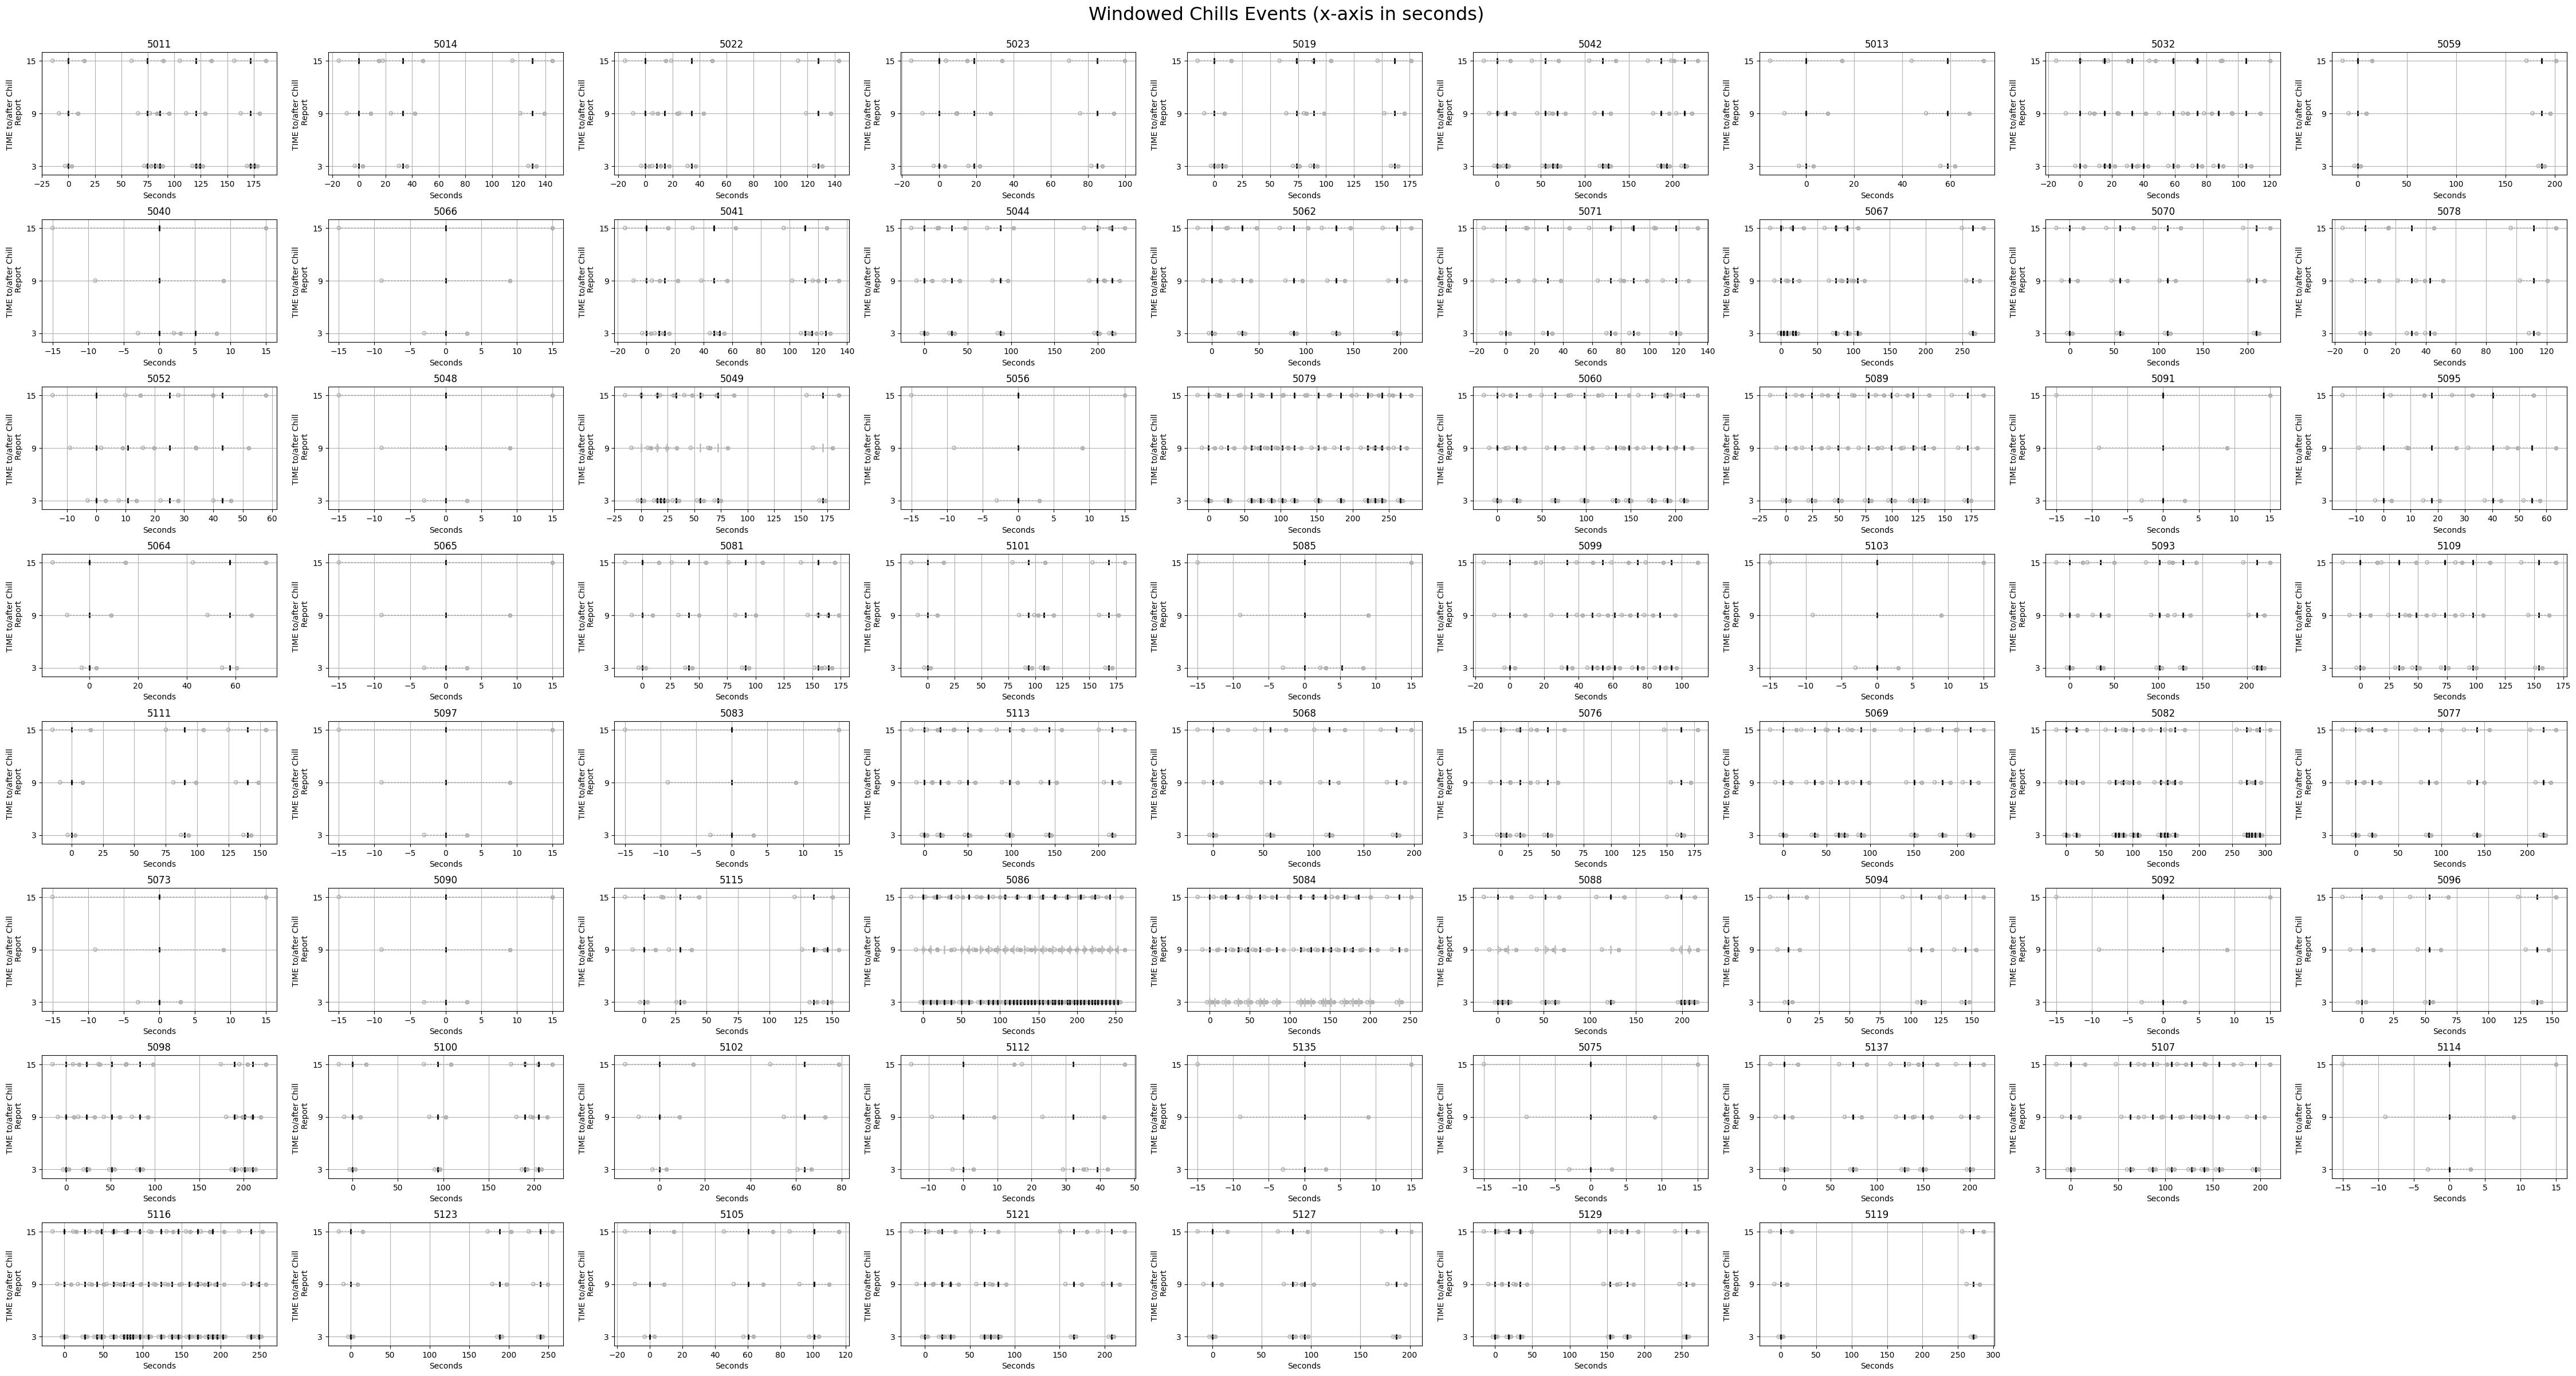

In [ ]:
# @title Plot Chill Events

chill_events = joblib.load(CHILL_EVENTS_DIR)
subjects_with_chills = chill_events["subjects"]
chills_events = chill_events["events"]

nrows = ncols = math.ceil(math.sqrt(len(subjects_with_chills)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*3))

times_ = [3, 9, 15]
start, end, steps = times_[0], times_[-1], times_[1]-times_[0]
for time_window in times_:

  for s, subject in enumerate(subjects_with_chills):

    ts = None
    for phase in stimuli_phases:
      if ts is None and len(chills_events[subject][phase])>0:
        ts = chills_events[subject][phase]
      elif len(chills_events[subject][phase])>0:
        np.hstack((ts, chills_events[subject][phase]))
    fs = chills_events[subject]["fs"]

    consolidated_chills = [ts[0]]
    for t in ts[1:]:
      if t - consolidated_chills[-1] > time_window:
        consolidated_chills.append(t)
    ts = np.array(consolidated_chills)

    # print(f"{subject}: {ts}")
    # ax.flatten()[s].stem(ts-ts.min(), np.ones(len(ts)), basefmt=" ", markerfmt="yo", linefmt="y-")
    ts_diff = np.diff(ts-ts.min())
    color_1 = "silver"
    color_ = "darkgray"
    color_2 = "black"
    if (ts_diff < (time_window + 0.1)).sum() > 0:
      ax.flatten()[s].vlines(x=ts-ts.min(), ymin=time_window-0.5, ymax=time_window+0.5, colors=color_1, linewidth=2.0)
    else:
      ax.flatten()[s].vlines(x=ts-ts.min(), ymin=time_window-0.3, ymax=time_window+0.3, colors=color_2, linewidth=2.0)
    for x in ts - ts.min():
        ax.flatten()[s].hlines(y=time_window, xmin=x-time_window, xmax=x+time_window, colors=color_, linewidth=1.5, linestyle="dotted")
    ax.flatten()[s].scatter(ts-ts.min()-time_window, np.zeros(len(ts))+time_window, edgecolors=color_, facecolors="none", s=20)
    ax.flatten()[s].scatter(ts-ts.min()+time_window, np.zeros(len(ts))+time_window, edgecolors=color_, facecolors=color_1, s=20)

    ax.flatten()[s].set_ylim(start-1, end+1)
    ax.flatten()[s].set_ylabel("TIME to/after Chill \n Report")
    ax.flatten()[s].set_xlabel("Seconds")
    ax.flatten()[s].set_title(subject)
    ax.flatten()[s].grid(True)
    ax.flatten()[s].set_yticks(times_)

  for s_ in range(s+1,len(ax.flatten())):
    ax.flatten()[s_].set_visible(False)

# for s_ in range(s+1,len(ax.flatten())):
#   ax.flatten()[s_].set_yticks(list(range(start, end, steps)))

fig.tight_layout()
fig.suptitle(f"Windowed Chills Events (x-axis in seconds)", fontsize=23)
fig.subplots_adjust(top=0.95)
fig.savefig(f"plots/windowed_chill_events.png")
# plt.close(fig)

# Plot Chills & Rest Signals

In [ ]:
chills_data = joblib.load(CHILLS_DATA_DIR)
non_chills_data = joblib.load(NON_CHILLS_DATA_DIR)

In [ ]:
# @title Plot Chill Onset & Offset Signals

from scipy.signal import decimate

# --> GET TOTAL NUMBER OF CHILL EVENTS
chills_count = dict()
for p, phase in enumerate(stimuli_phases):
  chills_count[phase] = 0
  for s, subject in enumerate(chills_data.keys()):
    chills_count[phase] += len(chills_data[subject][phase])
print(f"NO OF CHILLS EVENTS: {chills_count}")

# --> PLOT CHILLS EVENTS DATA FOR EACH STIMULI PHASE
# tracemalloc.start()
for p, phase in enumerate(stimuli_phases):
  idx = 0
  nrows = math.ceil(math.sqrt(chills_count[phase]))
  ncols = nrows

  plt.ioff()
  fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*1.5), dpi=100)
  for s, subject in enumerate(chills_data.keys()):
    for event in chills_data[subject][phase]:
      signal_ = None
      ts = None
      if (event["pre"] is not None) and (signal_ is None):
        signal_ = event["pre"]
        ts = np.linspace(-1 * PLOT_TIME_WINDOW, 0, signal_.shape[0])
      if (event["post"] is not None) and (signal_ is not None):
        signal_ = np.concatenate([signal_, event["post"]])
        ts = np.linspace(-1 * PLOT_TIME_WINDOW, PLOT_TIME_WINDOW, signal_.shape[0])
      elif (event["post"] is not None) and (signal_ is None):
        signal_ = event["post"]
        ts = np.linspace(0, PLOT_TIME_WINDOW, signal_.shape[0])
      if signal_ is not None:
        # print(signal_.shape)
        decimation_factor = int(0.005*signal_.shape[0])
        signal = signal_[::decimation_factor]
        ts = ts[::decimation_factor]
        for c in range(4):
          if c==0 or c==3:
            color_ = "grey" if subjects_epochs_validity.loc[subject, (phase, "EDA_Fit")]==True else "mistyrose"
          else:
            color_ = "grey"
          ax.flatten()[idx].plot(ts, signal[:,c] + (3-c), color=color_)
        ax.flatten()[idx].set_title(f"{subject}-{phase}")
        ax.flatten()[idx].set_yticks([0.5, 1.5, 2.5, 3.5])
        ax.flatten()[idx].set_yticklabels(["ECG", "RESP", "EMG", "GSR"])
        if ((ts.any() > 0) & ~(ts.any() < 0)) or (~(ts.any() > 0) & (ts.any() < 0)):
          ax.flatten()[idx].vlines(x=0, ymin=0, ymax=4.1, colors="black", linewidth=1.5, linestyle="dashed")
        idx += 1
      else:
        pass

  for s_ in range(chills_count[phase], nrows*ncols):
    ax.flatten()[s_].set_visible(False)

  if not os.path.exists("plots"):
    os.mkdir("plots")
  fig.suptitle(f"{TIME_WINDOW} {phase} chill signals", fontsize=24, y=1.02)
  fig.tight_layout()
  fig.savefig(f"plots/{phase}_chills.png", dpi=100)
  plt.close(fig)
  del fig, ax, idx, nrows, ncols, signal, signal_, ts
  print(f"{phase} signals plotted")

# mm_usage = tracemalloc.get_traced_memory()
# print(f"{np.array(mm_usage)/(1024*1024)} MB | {(mm_usage[1]-mm_usage[0])/(1024*1024)}MB")
# tracemalloc.stop()
gc.collect()

NO OF CHILLS EVENTS: {'stimulus1': 830, 'stimulus2': 895, 'stimulus3': 910}
stimulus1 signals plotted
stimulus2 signals plotted
stimulus3 signals plotted


192

In [ ]:
rest_phases

['pre_rest', 'post_rest']

In [ ]:
# @title Plot Non-Chills Signals

# --> GET TOTAL NUMBER OF REST
rest_count = dict()
for p, phase in enumerate(rest_phases):
  rest_count[phase] = 0
  for s, subject in enumerate(non_chills_data):
    rest_count[phase] += len(non_chills_data[subject][phase])
print(f"NO OF REST: {rest_count}")

# --> PLOT CHILLS EVENTS DATA FOR EACH STIMULI PHASE
tracemalloc.start()
for p, phase in enumerate(rest_phases):
  idx = 0
  nrows = math.ceil(math.sqrt(rest_count[phase]))
  ncols = nrows
  plt.ioff()
  fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*1.5), dpi=100)

  for s, subject in enumerate(non_chills_data):
    for signal_ in non_chills_data[subject][phase]:
      decimation_factor = int(0.005*signal_.shape[0])
      signal = signal_[::decimation_factor]
      ts = np.linspace(0, signal_.shape[0]/500, signal.shape[0])
      for c in range(4):
        if c==0 or c==3:
          color_ = "grey" if subjects_epochs_validity.loc[subject, (phase, "EDA_Fit")]==True else "mistyrose"
        else:
          color_ = "grey"
        ax.flatten()[idx].plot(ts, signal[:,c] + (3-c), color=color_)
      ax.flatten()[idx].set_title(f"{subject}-{phase}")
      ax.flatten()[idx].set_yticks([0.5, 1.5, 2.5, 3.5])
      ax.flatten()[idx].set_yticklabels(["ECG", "RESP", "EMG", "GSR"])
      idx += 1

  for s_ in range(rest_count[phase], nrows*ncols):
    ax.flatten()[s_].set_visible(False)

  if not os.path.exists("plots"):
    os.mkdir("plots")
  fig.suptitle(f"{phase} non-chill signals", fontsize=18)
  fig.tight_layout()
  fig.savefig(f"plots/{phase}_non_chill_signals.png", dpi=100)
  plt.close(fig)

mm_usage = tracemalloc.get_traced_memory()
print(f"{np.array(mm_usage)/(1024*1024)} MB | {(mm_usage[1]-mm_usage[0])/(1024*1024)}MB")
tracemalloc.stop()
gc.collect()

del fig, ax, idx, nrows, ncols

NO OF REST: {'pre_rest': 78, 'post_rest': 96}
[79.64348412 79.7925415 ] MB | 0.14905738830566406MB


# Feature Extraction

In [ ]:
subjects_info = fnc.subjects_info(STIMULUS_FILENAME)
subjects = os.listdir(XDF_DIR)
subjects = [subject[:-4] for subject in subjects]
phases = ['pre_rest', 'stimulus1', 'stimulus2', 'stimulus3', 'post_rest']
stimuli_phases = phases[1:-1]
rest_phases = ['pre_rest', 'post_rest']

In [ ]:
pre_chills_data = joblib.load(PRE_CHILLS_DATA_DIR)
chills_data = joblib.load(CHILLS_DATA_DIR)
non_chills_data = joblib.load(NON_CHILLS_DATA_DIR)

In [ ]:
# --> [gsr, emg, resp, ecg] <--> [0, 1, 2, 3]

In [ ]:
# @title Functions

from scipy import signal, integrate
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

def interpolate_peaks(peaks, time_duration, fs):

  r_peaks = np.where(peaks==1)[0]
  rr_intervals = np.diff(r_peaks)/fs

  time_rr = np.cumsum(rr_intervals)
  time_rr = np.insert(time_rr, 0, 0)
  time_points = np.arange(time_duration*fs)/fs

  kind = "cubic" if len(rr_intervals) > 4 else "linear"

  f_interp = interp1d(time_rr, peaks[r_peaks], kind=kind, bounds_error=False,
                    fill_value="extrapolate")
  rr_interp = f_interp(time_points)

  return rr_interp - np.mean(rr_interp)

def HRV_NN(peaks, sampling_rate):

  r_peak_indices = np.where(peaks == 1)[0]
  rr_intervals_samples = np.diff(r_peak_indices)
  rr_intervals = rr_intervals_samples/sampling_rate
  sdnn = np.std(rr_intervals)
  mean_nn = np.mean(rr_intervals)
  median_nn = np.median(rr_intervals)
  return mean_nn, sdnn, median_nn

def HRV_RMSSD(peaks, sampling_rate):

  r_peak_indices = np.where(peaks == 1)[0]
  rr_intervals_samples = np.diff(r_peak_indices)
  rr_intervals = rr_intervals_samples/sampling_rate

  diffs = np.diff(rr_intervals)
  squared_diffs = diffs**2
  mean_squared_diffs = np.mean(squared_diffs)
  rmssd = np.sqrt(mean_squared_diffs)

  return rmssd


def HRV_FREQUENCY(ecg, peaks, sampling_rate, max_freq=2.0, freq_ranges={"LF":(0.0, 0.16), "HF":(0.16, 0.4)}):

  assert max_freq <= 2.0

  if peaks.sum()<1:
    results = {}
    for band in freq_ranges:
      results[band] = None
    results["FF"] = None
    results["frequencies"] = None
    results["psd"] = None
  elif peaks.sum()>=1:

    fs_interp = 2*max_freq
    rr_intervals = interpolate_peaks(peaks, len(ecg)/fs, fs_interp)

    window = 'hann'
    nperseg = int(len(rr_intervals) / 1)  # Length of each segment
    noverlap = nperseg // 2  # 50% overlap

    frequencies, psd = signal.welch(
        rr_intervals, fs=fs_interp,
        window=window, nperseg=nperseg,
        noverlap=noverlap, detrend='constant',
        scaling='density'
        )

    def power_in_band(band):
          """Calculate power in a given frequency band"""
          mask = (frequencies >= band[0]) & (frequencies <= band[1])
          return np.trapz(psd[mask], frequencies[mask])

    results = {}

    for band in freq_ranges:
      results[band] = power_in_band(freq_ranges[band])
    results["FF"] = power_in_band((0, max_freq))
    results["frequencies"] = frequencies
    results["psd"] = psd
  else:
    results = {}
    for band in freq_ranges:
      results[band] = None
    results["FF"] = None
    results["frequencies"] = None
    results["psd"] = None

  return results

def poincare_indices(peaks, sampling_rate):
  r_peak_indices = np.where(peaks == 1)[0]
  rr_intervals_samples = np.diff(r_peak_indices)
  rr_intervals = rr_intervals_samples/sampling_rate

  rr_n = rr_intervals[:-1]
  rr_n1 = rr_intervals[1:]

  diff_rr = np.diff(rr_intervals) / np.sqrt(2)
  mean_rr = np.mean(rr_intervals)

  sd1 = np.std(diff_rr)
  sd2 = np.sqrt(2 * np.var(rr_intervals) - sd1**2)

  area = np.pi * sd1 * sd2

  ratio = sd1/sd2

  results = {
      "SD1": sd1,
      "SD2": sd2,
      "SD1_SD2_Ratio": ratio,
      "ellipse_area": area,
      "mean_RR": mean_rr
  }

  return results

def RRV_TIME(peaks, troughs, sampling_rate):
  peak_times = peaks/sampling_rate
  trough_times = troughs/sampling_rate

  breath_intervals = np.diff(peak_times)

  sdbb =  np.std(breath_intervals)
  if sdbb!=0 or sdbb!=math.nan:
    rmssd = np.sqrt( np.mean( np.diff(breath_intervals)**2 ) )
    sdsd = np.std( np.diff(breath_intervals) )
    return {
        "SDBB": sdbb,
        "RMSSD": rmssd,
        "SDSD": sdsd
    }
  else:
    return {
        "SDBB": math.nan,
        "RMSSD": math.nan,
        "SDSD": math.nan
    }

def RRV_FREQ(resp, peaks, troughs, sampling_rate, max_freq=2.0, freq_ranges={"LF":(0.0, 0.16), "HF":(0.16, 0.4)}):
  samples = np.concatenate([peaks, troughs])
  samples = np.sort(samples)

  peak_times = peaks/sampling_rate
  trough_times = troughs/sampling_rate

  times = np.concatenate([peak_times, trough_times])
  times = np.sort(times)

  breath_intervals = np.diff(times)
  time_points = np.cumsum(breath_intervals)
  time_points = np.insert(time_points, 0, 0)

  fs_interp = 2*max_freq
  t_interp = np.arange(time_points[0], time_points[-1], 1/fs_interp)
  kind = "cubic" if len(breath_intervals)>4 else "linear"
  f_method = interp1d(time_points, resp[samples], kind=kind)
  breath_intervals_interp = f_method(t_interp)

  breath_intervals_dereferenced = breath_intervals_interp - np.mean(breath_intervals_interp)

  window = signal.windows.hann(len(breath_intervals_dereferenced))
  breath_intervals_windowed = breath_intervals_dereferenced * window

  frequencies, psd = signal.welch(
      breath_intervals_windowed,
      fs=fs_interp,
      nperseg=len(breath_intervals_windowed),
      scaling="density"
  )

  def power_in_band(band):
    mask = (frequencies >= band[0]) & (frequencies <= band[1])
    return np.trapz(psd[mask], frequencies[mask])

  results = {}
  for band in freq_ranges:
    results[band] = power_in_band(freq_ranges[band])
  results["FF"] = power_in_band((0, max_freq))
  results["frequencies"] = frequencies
  results["psd"] = psd

  return results

def CARDIORESPIRATORY_COUPLING(resp, peaks, fs):

  if peaks.sum()<1:
    return {
      "coherence": None,
      "phase_sync": None
      }
  else:
    resp_analytical = signal.hilbert(resp)
    resp_phase = np.angle(resp_analytical)

    rr_intervals = interpolate_peaks(peaks, len(resp)/fs, fs)

    f, Cxy = signal.coherence(resp, rr_intervals, fs, nperseg=int(0.35*len(resp)))
    resp_band = (f>=0.15) & (f<=0.4)
    coherence = np.mean(Cxy[resp_band])

    phase_diff = resp_phase - np.angle(signal.hilbert(rr_intervals))
    sync_index = np.abs(np.mean(np.exp(1j * phase_diff)))

    return {
        "coherence": coherence,
        "phase_sync": sync_index
    }

def EDA_STATISTICS(eda_signal):
  mean_value = np.mean(eda_signal)
  median_value = np.median(eda_signal)
  std_dev = np.std(eda_signal)
  skewness_value = skew(eda_signal)
  kurtosis_value = kurtosis(eda_signal)

  # Store the results in a dictionary
  stats_dict = {
      'mean': mean_value,
      'median': median_value,
      'std': std_dev,
      'skew': skewness_value,
      'kurtosis': kurtosis_value
  }

  return stats_dict

In [ ]:
# @title Generate Pre-Chills Features Dataset

pre_chill_features = pd.DataFrame()
psds = None

for p, phase in enumerate(pre_chills_data.keys()):
  for subject in tqdm(list(pre_chills_data[phase].keys()),
                      total = len(pre_chills_data[phase]),
                      desc=f"Processing phase:{phase}"):
    print(phase, subject)
    for a, arr in enumerate(pre_chills_data[phase][subject]):

      fs = arr.shape[0]/TIME_WINDOW
      # print(f"Sampling Rate: {fs}")

      # --> signals
      ecg = arr[:, 3]
      resp = arr[:, 2]
      emg = arr[:, 1]
      eda = arr[:, 0]

      # --> heart rate time-domain features
      ecg_peaks, info = nk.ecg_peaks(ecg, fs, correct_artifacts=True)
      heart_rates = nk.ecg_rate(ecg_peaks, fs)
      mean_hr = np.mean(heart_rates)
      hrv = np.std(heart_rates)
      mean_nn, sdnn, median_nn = HRV_NN(np.array(ecg_peaks["ECG_R_Peaks"]), fs)
      rmssd = HRV_RMSSD(np.array(ecg_peaks["ECG_R_Peaks"]), fs)

      # --> heart rate frequency-domain features
      hrv_freq = HRV_FREQUENCY(ecg, np.array(ecg_peaks["ECG_R_Peaks"]), fs)

      # --> heart rate non-linear features
      poincare = poincare_indices(np.array(ecg_peaks["ECG_R_Peaks"]), fs)
      SampEn = nk.entropy_sample(ecg)[0]

      # --> Respiratory Rate Time Domain Features
      clean_resp = nk.rsp_clean(resp, sampling_rate=fs)
      clean_resp -= np.mean(clean_resp)
      resp_rates = nk.rsp_rate(clean_resp, sampling_rate=fs, method="xcorr")
      mean_rr = np.mean(resp_rates)

      signal_std = np.std(clean_resp)
      resp_peaks, _ = signal.find_peaks(
          clean_resp, height=0.2*signal_std, distance=0.5*fs,
          prominence=0.5*signal_std)
      troughs, _ = signal.find_peaks(
          -clean_resp, height=-0.2*signal_std, distance=0.5*fs,
          prominence=0.5*signal_std)
      rrv_time = RRV_TIME(resp_peaks, troughs, fs)

      # -->  Respiratory Rate Frequency Domain Features
      rrv_freq = RRV_FREQ(clean_resp, resp_peaks, troughs, fs)

      # --> Cardiorespiratory Coupling
      CRC = CARDIORESPIRATORY_COUPLING(
          clean_resp, np.array(ecg_peaks["ECG_R_Peaks"]), fs
          )

      # --> EDA features
      eda = nk.eda_process(eda, sampling_rate=fs)[0]
        # --> Statistical features: mean, median, std, skew, kurtosis
      eda_stats = EDA_STATISTICS(np.array(eda["EDA_Raw"]))
        # --> Tonic Parameters: Mean Skin Conductance Level
      SCL = np.mean(eda["EDA_Tonic"])
        # --> Phasic Skin Conductance Response Parameters
      SCR = {}
          #--> Amplitude
      amplitude_indices = np.where(eda["SCR_Amplitude"]!=0)[0]
      amplitudes = np.array(eda["SCR_Amplitude"][amplitude_indices])
      SCR["amplitude_mean"] = amplitudes.mean()
      SCR["amplitudes_std"] = amplitudes.std()
          # --> Rise Time
      rise_indices = np.where(eda["SCR_RiseTime"]!=0)[0]
      rise_times = np.array(eda["SCR_RiseTime"][rise_indices])
      SCR["risetime_mean"] = rise_times.mean()
      SCR["risetime_std"] = rise_times.std()
          # --> Recovery Time
      recovery_times = np.where(eda["SCR_Recovery"]==1)[0]/fs
      SCR["recovery_mean"] = recovery_times.mean()
      SCR["recovery_std"] = recovery_times.std()
        # --> Frequency
      phasic_signal = np.array(eda["EDA_Phasic"])
      n = len(phasic_signal)
      frequencies = fftfreq(n, 1/fs)[:n//2]
      fft_values = fft(phasic_signal)[:n//2]
      frequencies = frequencies[:n//2]
      SCR["domnt_freq"] = frequencies[np.argmax(fft_values)]



      # print(f"MeanHR: {mean_hr}, hrv:{hrv}, NN(mean, std, median): {(mean_nn, sdnn, median_nn)}, RMSSD:{rmssd}")
      # print(f"HRV_FREQ(LF, HF, FF): {hrv_freq['LF'], hrv_freq['HF'], hrv_freq['FF']}")
      # print(f"HRV_poincare: {poincare}, SampEn: {SampEn}")
      # print(f"MeanRR: {mean_rr}, RRV_time: {rrv_time}")
      # print(f"RRV_FREQ(LF, HF, FF): {rrv_freq['LF']}, {rrv_freq['HF']}, {rrv_freq['FF']}")
      # print(f"CRC: {CRC}")
      # print(f"EDA_STATS: {eda_stats}")
      # print(f"SCR: {SCR}")
      # print(f"SCL: {SCL}")

      # --> ARRANGE INSTANCE FOR FEATURE DATASET
      instance = {}
      instance["id"] = f"{subject}_pre_{phases.index(phase)+1}_{a}"
        #--> Heart Rate Features
      instance["mean_HR"], instance["HRV"] = (mean_hr, hrv)
      instance["mean_NN"], instance["std_NN"], instance["median_NN"], instance["HR_RMSSD"] = (mean_nn, sdnn, median_nn, rmssd)
      instance["HRV_LF"], instance["HRV_HF"], instance["HRV_FF"] = (hrv_freq['LF'], hrv_freq['HF'], hrv_freq['FF'])
      instance["SD1"], instance["SD2"], instance["SD1/SD2"], instance["ellipse_area"] = (
          poincare["SD1"],
          poincare["SD2"],
          poincare["SD1_SD2_Ratio"],
          poincare["ellipse_area"])
      instance["ECG_SampEn"] = SampEn
        # --> Respiration Rate Features
      instance["mean_RR"] = mean_rr
      instance["SDBB"], instance["RR_RMSSD"], instance["SDSD"] = (rrv_time["SDBB"], rrv_time["RMSSD"], rrv_time["SDSD"] )
      instance["RRV_LF"], instance["RRV_HF"], instance["RRV_FF"] = (rrv_freq['LF'], rrv_freq['HF'], rrv_freq['FF'])
      instance["CRC_coherence"], instance["CRC_phase_sync"] = (CRC["coherence"], CRC["phase_sync"])
        # --> Electrodermal Activity Features
      for k in eda_stats.keys():
        instance[f"EDA_{k}"] = eda_stats[k]
      for k in SCR.keys():
        instance[f"phasic_{k}"] = SCR[k]
      instance["EDA_SCL"] = SCL
      instance["stimuli"] = phase
      instance["label"] = "PRE-CHILL"
      instance = pd.DataFrame([instance])

      pre_chill_features = pd.concat([pre_chill_features, instance], ignore_index=True)

      # print(instance)
      # print("-------------------------------------------------------------------------------------------------------------------------------------------")

    print(f"subject {subject}, phase {phase}; pre_chill feature extraction complete")
    clear_output(wait=False)

pre_chill_features.to_csv(f"{FEATURES_DIR}/pre_chills_features.csv")
pre_chill_features.head()

Processing phase:stimulus3: 100%|██████████| 70/70 [04:57<00:00,  4.24s/it]


id    mean_HR       HRV   mean_NN    std_NN  median_NN  HR_RMSSD  \
0  5011_pre_2_0  72.089660  2.489981  0.833275  0.029152   0.834331  0.038387   
1  5011_pre_2_1  75.540718  4.994606  0.797627  0.052237   0.802395  0.040105   
2  5011_pre_2_2  82.835827  3.662570  0.725706  0.032108   0.732535  0.029665   
3  5011_pre_2_3  73.816007  7.297155  0.820594  0.081343   0.810379  0.074963   
4  5011_pre_2_4  75.971988  2.179236  0.790419  0.023448   0.785429  0.028591   

         HRV_LF        HRV_HF        HRV_FF  ...  phasic_amplitude_mean  \
0  8.277735e-34  8.560351e-34  1.070365e-32  ...               0.000950   
1  3.087817e-35  1.364309e-33  9.788590e-33  ...               0.034838   
2  1.160267e-33  1.212387e-33  1.182124e-32  ...               0.004857   
3  1.480310e-34  9.371188e-34  1.383786e-32  ...                    NaN   
4  2.730352e-33  9.347443e-34  1.196146e-32  ...               0.010436   

   phasic_amplitudes_std  phasic_risetime_mean  phasic_risetime_std  \
0               0.000726              0.201597              0.06986   
1               0.025530              2.180639              0.58982   
2               0.004673              0.638323              0.36361   
3                    NaN                   NaN                  NaN   
4               0.005985              0.438551              0.51581   

   phasic_recovery_mean  phasic_recovery_std  phasic_domnt_freq   EDA_SCL  \
0              8.965070             3.030938           0.200000  0.888913   
1             12.514970             0.000000           0.133333  0.581640   
2              7.187625             4.794362           0.066667  0.431950   
3              7.691707             3.568667           0.133333  0.578722   
4              7.131737             4.258850           0.000000  0.873461   

     stimuli      label  
0  stimulus1  PRE-CHILL  
1  stimulus1  PRE-CHILL  
2  stimulus1  PRE-CHILL  
3  stimulus1  PRE-CHILL  
4  stimulus1  PRE-CHILL  

[5 rows x 39 columns]

In [ ]:
# @title Generate Chills Features Dataset

chills_features = pd.DataFrame()
psds = None

for p, phase in enumerate(chills_data.keys()):
  for subject in tqdm(list(chills_data[phase].keys()),
                      total = len(chills_data[phase]),
                      desc=f"Processing phase:{phase}"):
    print(phase, subject)
    for a, arr in enumerate(chills_data[phase][subject]):

      fs = arr.shape[0]/(2 * TIME_WINDOW//3)
      print(f"Sampling Rate: {fs}")

      # --> signals
      ecg = arr[:, 3]
      resp = arr[:, 2]
      emg = arr[:, 1]
      eda = arr[:, 0]

      # --> heart rate time-domain features
      ecg_peaks, info = nk.ecg_peaks(ecg, fs, correct_artifacts=True)
      heart_rates = nk.ecg_rate(ecg_peaks, fs)
      mean_hr = np.mean(heart_rates)
      hrv = np.std(heart_rates)
      mean_nn, sdnn, median_nn = HRV_NN(np.array(ecg_peaks["ECG_R_Peaks"]), fs)
      rmssd = HRV_RMSSD(np.array(ecg_peaks["ECG_R_Peaks"]), fs)

      # --> heart rate frequency-domain features
      hrv_freq = HRV_FREQUENCY(ecg, np.array(ecg_peaks["ECG_R_Peaks"]), fs)

      # --> heart rate non-linear features
      poincare = poincare_indices(np.array(ecg_peaks["ECG_R_Peaks"]), fs)
      SampEn = nk.entropy_sample(ecg)[0]

      # --> Respiratory Rate Time Domain Features
      clean_resp = nk.rsp_clean(resp, sampling_rate=fs)
      clean_resp -= np.mean(clean_resp)
      resp_rates = nk.rsp_rate(clean_resp, sampling_rate=fs, method="xcorr")
      mean_rr = np.mean(resp_rates)

      signal_std = np.std(clean_resp)
      resp_peaks, _ = signal.find_peaks(
          clean_resp, height=0.2*signal_std, distance=0.5*fs,
          prominence=0.5*signal_std)
      troughs, _ = signal.find_peaks(
          -clean_resp, height=-0.2*signal_std, distance=0.5*fs,
          prominence=0.5*signal_std)
      rrv_time = RRV_TIME(resp_peaks, troughs, fs)

      # -->  Respiratory Rate Frequency Domain Features
      rrv_freq = RRV_FREQ(clean_resp, resp_peaks, troughs, fs)

      # --> Cardiorespiratory Coupling
      CRC = CARDIORESPIRATORY_COUPLING(
          clean_resp, np.array(ecg_peaks["ECG_R_Peaks"]), fs
          )

      # --> EDA features
      eda = nk.eda_process(eda, sampling_rate=fs)[0]
        # --> Statistical features: mean, median, std, skew, kurtosis
      eda_stats = EDA_STATISTICS(np.array(eda["EDA_Raw"]))
        # --> Tonic Parameters: Mean Skin Conductance Level
      SCL = np.mean(eda["EDA_Tonic"])
        # --> Phasic Skin Conductance Response Parameters
      SCR = {}
          #--> Amplitude
      amplitude_indices = np.where(eda["SCR_Amplitude"]!=0)[0]
      amplitudes = np.array(eda["SCR_Amplitude"][amplitude_indices])
      SCR["amplitude_mean"] = amplitudes.mean()
      SCR["amplitudes_std"] = amplitudes.std()
          # --> Rise Time
      rise_indices = np.where(eda["SCR_RiseTime"]!=0)[0]
      rise_times = np.array(eda["SCR_RiseTime"][rise_indices])
      SCR["risetime_mean"] = rise_times.mean()
      SCR["risetime_std"] = rise_times.std()
          # --> Recovery Time
      recovery_times = np.where(eda["SCR_Recovery"]==1)[0]/fs
      SCR["recovery_mean"] = recovery_times.mean()
      SCR["recovery_std"] = recovery_times.std()
        # --> Frequency
      phasic_signal = np.array(eda["EDA_Phasic"])
      n = len(phasic_signal)
      frequencies = fftfreq(n, 1/fs)[:n//2]
      fft_values = fft(phasic_signal)[:n//2]
      frequencies = frequencies[:n//2]
      SCR["domnt_freq"] = frequencies[np.argmax(fft_values)]



      # print(f"MeanHR: {mean_hr}, hrv:{hrv}, NN(mean, std, median): {(mean_nn, sdnn, median_nn)}, RMSSD:{rmssd}")
      # print(f"HRV_FREQ(LF, HF, FF): {hrv_freq['LF'], hrv_freq['HF'], hrv_freq['FF']}")
      # print(f"HRV_poincare: {poincare}, SampEn: {SampEn}")
      # print(f"MeanRR: {mean_rr}, RRV_time: {rrv_time}")
      # print(f"RRV_FREQ(LF, HF, FF): {rrv_freq['LF']}, {rrv_freq['HF']}, {rrv_freq['FF']}")
      # print(f"CRC: {CRC}")
      # print(f"EDA_STATS: {eda_stats}")
      # print(f"SCR: {SCR}")
      # print(f"SCL: {SCL}")

      # --> ARRANGE INSTANCE FOR FEATURE DATASET
      instance = {}
      instance["id"] = f"{subject}_chill_{phases.index(phase)+1}_{a}"
        #--> Heart Rate Features
      instance["mean_HR"], instance["HRV"] = (mean_hr, hrv)
      instance["mean_NN"], instance["std_NN"], instance["median_NN"], instance["HR_RMSSD"] = (mean_nn, sdnn, median_nn, rmssd)
      instance["HRV_LF"], instance["HRV_HF"], instance["HRV_FF"] = (hrv_freq['LF'], hrv_freq['HF'], hrv_freq['FF'])
      instance["SD1"], instance["SD2"], instance["SD1/SD2"], instance["ellipse_area"] = (
          poincare["SD1"],
          poincare["SD2"],
          poincare["SD1_SD2_Ratio"],
          poincare["ellipse_area"])
      instance["ECG_SampEn"] = SampEn
        # --> Respiration Rate Features
      instance["mean_RR"] = mean_rr
      instance["SDBB"], instance["RR_RMSSD"], instance["SDSD"] = (rrv_time["SDBB"], rrv_time["RMSSD"], rrv_time["SDSD"] )
      instance["RRV_LF"], instance["RRV_HF"], instance["RRV_FF"] = (rrv_freq['LF'], rrv_freq['HF'], rrv_freq['FF'])
      instance["CRC_coherence"], instance["CRC_phase_sync"] = (CRC["coherence"], CRC["phase_sync"])
        # --> Electrodermal Activity Features
      for k in eda_stats.keys():
        instance[f"EDA_{k}"] = eda_stats[k]
      for k in SCR.keys():
        instance[f"phasic_{k}"] = SCR[k]
      instance["EDA_SCL"] = SCL
      instance["stimuli"] = phase
      instance["label"] = "CHILL"
      instance = pd.DataFrame([instance])

      chills_features = pd.concat([chills_features, instance], ignore_index=True)

      # print(instance)
      # print("-------------------------------------------------------------------------------------------------------------------------------------------")

    print(f"subject {subject}, phase {phase}; chills feature extraction complete")
    clear_output(wait=False)

chills_features.to_csv(f"{FEATURES_DIR}/chills_features.csv")
chills_features.head()

Processing phase:stimulus3: 100%|██████████| 70/70 [00:33<00:00,  2.07it/s]


id    mean_HR       HRV   mean_NN    std_NN  median_NN  \
0  5011_chill_2_0  72.314402  2.767769  0.830884  0.032039   0.844311   
1  5011_chill_2_1  74.295579  2.579269  0.808565  0.029501   0.808383   
2  5011_chill_2_2  78.343104  3.492746  0.767374  0.035496   0.758483   
3  5011_chill_2_3  70.780749  1.921181  0.848303  0.023785   0.848303   
4  5014_chill_2_0  64.116561  7.900749  0.950199  0.123731   0.931275   

   HR_RMSSD        HRV_LF        HRV_HF        HRV_FF  ...  \
0  0.037090  2.574779e-34  1.548011e-33  9.334383e-33  ...   
1  0.031899  1.043346e-34  9.052105e-34  1.579323e-32  ...   
2  0.029552  3.352687e-34  3.647011e-34  1.055967e-32  ...   
3  0.031193  5.629066e-34  1.161217e-33  1.086932e-32  ...   
4  0.087715  4.094810e-34  9.225993e-34  8.961396e-33  ...   

   phasic_amplitude_mean  phasic_amplitudes_std  phasic_risetime_mean  \
0               0.014967               0.000000              1.588822   
1               0.004378               0.003504              0.707086   
2                    NaN                    NaN                   NaN   
3               0.010010               0.000334              0.292415   
4               0.000248               0.000051              0.303785   

   phasic_risetime_std  phasic_recovery_mean  phasic_recovery_std  \
0             0.000000              9.566866             0.000000   
1             0.540442              6.256986             2.728797   
2                  NaN              6.864271             1.548902   
3             0.004350              6.350632             1.935713   
4             0.024900              7.507968             1.270916   

   phasic_domnt_freq   EDA_SCL    stimuli  label  
0                0.1  0.857988  stimulus1  CHILL  
1                0.1  0.584450  stimulus1  CHILL  
2                0.0  0.437260  stimulus1  CHILL  
3                0.0  0.708692  stimulus1  CHILL  
4              250.9  0.095047  stimulus1  CHILL  

[5 rows x 39 columns]

In [ ]:
# @title Generate Non-chills Features Dataset

non_chills_features = pd.DataFrame()
psds = None

for p, phase in enumerate(non_chills_data.keys()):
  for subject in tqdm(list(non_chills_data[phase].keys()),
                      total = len(non_chills_data[phase]),
                      desc=f"Processing {phase} phase: "):
    # print(phase, subject)
    for d, data in enumerate(non_chills_data[phase][subject]):

      fs = data.shape[0] / (20*TIME_WINDOW)
      print(f"{subject}, {phase} sampling rate: {fs}")

      T, _ = data.shape
      epoch_length = int(TIME_WINDOW*fs)
      num_epochs = T // epoch_length
      overlap = int(0.1*epoch_length)
      step_size = epoch_length - overlap

      for i in range(num_epochs):
        # --> SELECT TIME_WINDOW(15s) epoch from NON-CHILL data
        start_idx = i*step_size
        end_idx = start_idx+epoch_length
        if end_idx>T:
          break
        arr = data[start_idx:end_idx, :]

        # --> signals
        ecg = arr[:, 3]
        resp = arr[:, 2]
        emg = arr[:, 1]
        eda = arr[:, 0]

        # --> heart rate time-domain features
        ecg_peaks, info = nk.ecg_peaks(ecg, fs, correct_artifacts=True)
        heart_rates = nk.ecg_rate(ecg_peaks, fs)
        mean_hr = np.mean(heart_rates)
        hrv = np.std(heart_rates)
        mean_nn, sdnn, median_nn = HRV_NN(np.array(ecg_peaks["ECG_R_Peaks"]), fs)
        rmssd = HRV_RMSSD(np.array(ecg_peaks["ECG_R_Peaks"]), fs)

        # --> heart rate frequency-domain features
        hrv_freq = HRV_FREQUENCY(ecg, np.array(ecg_peaks["ECG_R_Peaks"]), fs)

        # --> heart rate non-linear features
        poincare = poincare_indices(np.array(ecg_peaks["ECG_R_Peaks"]), fs)
        SampEn = nk.entropy_sample(ecg)[0]

        # --> Respiratory Rate Time Domain Features
        clean_resp = nk.rsp_clean(resp, sampling_rate=fs)
        clean_resp -= np.mean(clean_resp)
        resp_rates = nk.rsp_rate(clean_resp, sampling_rate=fs, method="xcorr")
        mean_rr = np.mean(resp_rates)

        signal_std = np.std(clean_resp)
        resp_peaks, _ = signal.find_peaks(
            clean_resp, height=0.2*signal_std, distance=0.5*fs,
            prominence=0.5*signal_std)
        troughs, _ = signal.find_peaks(
            -clean_resp, height=-0.2*signal_std, distance=0.5*fs,
            prominence=0.5*signal_std)
        rrv_time = RRV_TIME(resp_peaks, troughs, fs)

        # -->  Respiratory Rate Frequency Domain Features
        rrv_freq = RRV_FREQ(clean_resp, resp_peaks, troughs, fs)

        # --> Cardiorespiratory Coupling
        CRC = CARDIORESPIRATORY_COUPLING(
            clean_resp, np.array(ecg_peaks["ECG_R_Peaks"]), fs
            )

        # --> EDA features
        eda = nk.eda_process(eda, sampling_rate=fs)[0]
          # --> Statistical features: mean, median, std, skew, kurtosis
        eda_stats = EDA_STATISTICS(np.array(eda["EDA_Raw"]))
          # --> Tonic Parameters: Mean Skin Conductance Level
        SCL = np.mean(eda["EDA_Tonic"])
          # --> Phasic Skin Conductance Response Parameters
        SCR = {}
            #--> Amplitude
        amplitude_indices = np.where(eda["SCR_Amplitude"]!=0)[0]
        amplitudes = np.array(eda["SCR_Amplitude"][amplitude_indices])
        SCR["amplitude_mean"] = amplitudes.mean()
        SCR["amplitudes_std"] = amplitudes.std()
            # --> Rise Time
        rise_indices = np.where(eda["SCR_RiseTime"]!=0)[0]
        rise_times = np.array(eda["SCR_RiseTime"][rise_indices])
        SCR["risetime_mean"] = rise_times.mean()
        SCR["risetime_std"] = rise_times.std()
            # --> Recovery Time
        recovery_times = np.where(eda["SCR_Recovery"]==1)[0]/fs
        SCR["recovery_mean"] = recovery_times.mean()
        SCR["recovery_std"] = recovery_times.std()
          # --> Frequency
        phasic_signal = np.array(eda["EDA_Phasic"])
        n = len(phasic_signal)
        frequencies = fftfreq(n, 1/fs)[:n//2]
        fft_values = fft(phasic_signal)[:n//2]
        frequencies = frequencies[:n//2]
        SCR["domnt_freq"] = frequencies[np.argmax(fft_values)]



        # print(f"MeanHR: {mean_hr}, hrv:{hrv}, NN(mean, std, median): {(mean_nn, sdnn, median_nn)}, RMSSD:{rmssd}")
        # print(f"HRV_FREQ(LF, HF, FF): {hrv_freq['LF'], hrv_freq['HF'], hrv_freq['FF']}")
        # print(f"HRV_poincare: {poincare}, SampEn: {SampEn}")
        # print(f"MeanRR: {mean_rr}, RRV_time: {rrv_time}")
        # print(f"RRV_FREQ(LF, HF, FF): {rrv_freq['LF']}, {rrv_freq['HF']}, {rrv_freq['FF']}")
        # print(f"CRC: {CRC}")
        # print(f"EDA_STATS: {eda_stats}")
        # print(f"SCR: {SCR}")
        # print(f"SCL: {SCL}")

        # --> ARRANGE INSTANCE FOR FEATURE DATASET
        instance = {}
        instance["id"] = f"{subject}_{phases.index(phase)+1}_{i}"
          #--> Heart Rate Features
        instance["mean_HR"], instance["HRV"] = (mean_hr, hrv)
        instance["mean_NN"], instance["std_NN"], instance["median_NN"], instance["HR_RMSSD"] = (mean_nn, sdnn, median_nn, rmssd)
        instance["HRV_LF"], instance["HRV_HF"], instance["HRV_FF"] = (hrv_freq['LF'], hrv_freq['HF'], hrv_freq['FF'])
        instance["SD1"], instance["SD2"], instance["SD1/SD2"], instance["ellipse_area"] = (
            poincare["SD1"],
            poincare["SD2"],
            poincare["SD1_SD2_Ratio"],
            poincare["ellipse_area"])
        instance["ECG_SampEn"] = SampEn
          # --> Respiration Rate Features
        instance["mean_RR"] = mean_rr
        instance["SDBB"], instance["RR_RMSSD"], instance["SDSD"] = (rrv_time["SDBB"], rrv_time["RMSSD"], rrv_time["SDSD"] )
        instance["RRV_LF"], instance["RRV_HF"], instance["RRV_FF"] = (rrv_freq['LF'], rrv_freq['HF'], rrv_freq['FF'])
        instance["CRC_coherence"], instance["CRC_phase_sync"] = (CRC["coherence"], CRC["phase_sync"])
          # --> Electrodermal Activity Features
        for k in eda_stats.keys():
          instance[f"EDA_{k}"] = eda_stats[k]
        for k in SCR.keys():
          instance[f"phasic_{k}"] = SCR[k]
        instance["EDA_SCL"] = SCL
        instance["stimuli"] = phase
        instance["label"] = "NON-CHILL"
        instance = pd.DataFrame([instance])

        non_chills_features = pd.concat([non_chills_features, instance], ignore_index=True)

        # print(instance)
        # print("-------------------------------------------------------------------------------------------------------------------------------------------")

      print(f"subject {subject}, phase {phase}; chills feature extraction complete")
      clear_output(wait=True)
      time.sleep(0.025)

non_chills_features.to_csv(f"{FEATURES_DIR}/non_chills_features.csv")
non_chills_features.head()

Processing post_rest phase: 100%|██████████| 91/91 [17:55<00:00, 11.82s/it]


id    mean_HR       HRV   mean_NN    std_NN  median_NN  HR_RMSSD  \
0  5011_1_0  78.538344  5.399863  0.767576  0.054196   0.759481  0.041203   
1  5011_1_1  78.701113  8.264162  0.769794  0.073413   0.772455  0.037254   
2  5011_1_2  74.737061  6.773440  0.809323  0.074006   0.838323  0.068267   
3  5011_1_3  78.590963  3.632945  0.765026  0.035130   0.767465  0.025520   
4  5011_1_4  80.290002  3.898246  0.749028  0.036758   0.756487  0.023462   

         HRV_LF        HRV_HF        HRV_FF  ...  phasic_amplitude_mean  \
0  3.410922e-34  9.500403e-34  1.050324e-32  ...                    NaN   
1  1.541559e-33  1.707783e-33  1.848582e-32  ...               0.000781   
2  6.874474e-34  1.092031e-34  1.079296e-32  ...               0.001304   
3  3.891854e-34  1.039372e-33  1.695609e-32  ...               0.000724   
4  8.965896e-34  3.260802e-33  1.728646e-32  ...                    NaN   

   phasic_amplitudes_std  phasic_risetime_mean  phasic_risetime_std  \
0                    NaN                   NaN                  NaN   
1               0.000283              0.272788             0.129712   
2               0.001495              0.415455             0.386825   
3               0.000607              0.259271             0.168571   
4                    NaN                   NaN                  NaN   

   phasic_recovery_mean  phasic_recovery_std  phasic_domnt_freq   EDA_SCL  \
0                   NaN                  NaN           0.000000  0.240397   
1             11.124640             3.203107           0.000000  0.453244   
2              9.312708             3.991557           0.666667  0.596358   
3             10.348010             3.214465           0.000000  0.719635   
4              8.907809             3.559366           0.266667  0.828605   

    stimuli      label  
0  pre_rest  NON-CHILL  
1  pre_rest  NON-CHILL  
2  pre_rest  NON-CHILL  
3  pre_rest  NON-CHILL  
4  pre_rest  NON-CHILL  

[5 rows x 39 columns]

# EDA

#### Data Cleaning

In [ ]:
from scipy import stats
from sklearn.feature_selection import mutual_info_classif, f_classif
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests

from matplotlib.cm import get_cmap
import random

In [ ]:
# pre_chills_df = pd.read_csv(f"{FEATURES_DIR}/pre_chills_features.csv", index_col=0)
# chills_df = pd.read_csv(f"{FEATURES_DIR}/chills_features.csv", index_col=0)
# non_chills_df = pd.read_csv(f"{FEATURES_DIR}/non_chills_features.csv", index_col=0)
all_df = pd.read_csv(f"{FEATURES_DIR}/all_features.csv", index_col=0)
print(f"(no NON-CHILL, no CHILL): {(all_df['label']=='NON-CHILL').sum(), len(all_df)-(all_df['label']=='NON-CHILL').sum()}")
N_SAMPLES = all_df.shape[0]
print(f"Dataset Size: {all_df.shape}")

(no NON-CHILL, no CHILL): (8700, 3495)
Dataset Size: (12195, 39)


In [ ]:
NAN_VALS_DF = all_df.isna().sum()
EXTREME_NANS = NAN_VALS_DF[NAN_VALS_DF>int(0.3*N_SAMPLES)]
print(EXTREME_NANS)
print(" ")
print(f"Dataset Size: {all_df.shape}")
NAN_VALS_DF = all_df.isna().sum()
print(f"NO NAN VALS/DATASET_SIZE: {NAN_VALS_DF.sum()}/{all_df.shape[0]*all_df.shape[1]} = {NAN_VALS_DF.sum()/(all_df.shape[0]*all_df.shape[1])} ")

SDBB                      8029
RR_RMSSD                 11526
SDSD                     11526
CRC_coherence            12195
phasic_amplitude_mean     4718
phasic_amplitudes_std     4718
phasic_risetime_mean      4718
phasic_risetime_std       4718
phasic_recovery_mean      3767
phasic_recovery_std       3767
dtype: int64
 
Dataset Size: (12195, 39)
NO NAN VALS/DATASET_SIZE: 71404/475605 = 0.15013298850937226 


In [ ]:
all_df = all_df.drop(["CRC_coherence"], axis=1)

num_cols = all_df.select_dtypes(include=["number"]).columns
labels = all_df["label"].unique()

for label in labels:
  df = all_df[num_cols].fillna(all_df[num_cols].mean())
  all_df.loc[all_df["label"] == label, num_cols] = df

In [ ]:
NAN_VALS_DF = all_df.isna().sum()
EXTREME_NANS = NAN_VALS_DF[NAN_VALS_DF>int(0.3*N_SAMPLES)]
print(EXTREME_NANS)
print(" ")
print(f"Dataset Size: {all_df.shape}")
NAN_VALS_DF = all_df.isna().sum()
print(f"NO NAN VALS/DATASET_SIZE: {NAN_VALS_DF.sum()}/{all_df.shape[0]*all_df.shape[1]} = {NAN_VALS_DF.sum()/(all_df.shape[0]*all_df.shape[1])} ")
NAN_VALS_DF[NAN_VALS_DF>int(0.2*N_SAMPLES)]

Series([], dtype: int64)
 
Dataset Size: (12195, 38)
NO NAN VALS/DATASET_SIZE: 0/463410 = 0.0 


Series([], dtype: int64)

In [ ]:
sum(all_df.isna().sum())

0

In [ ]:
# all_df["binary_label"] = all_df["label"]
# all_df["binary_label"][all_df["binary_label"]=="PRE-CHILL"] = "CHILL"
clear_output(wait=True)
time.sleep(0.025)
all_df.head()

id    stimuli      label    mean_HR       HRV  mean_NN    std_NN  \
0  5002_5_0  post_rest  NON-CHILL  63.360979  1.029105   0.9472  0.016522   
1  5002_5_1  post_rest  NON-CHILL  59.005010  0.680279   1.0170  0.013304   
2  5002_5_2  post_rest  NON-CHILL  59.446527  1.574107   1.0100  0.028538   
3  5002_5_3  post_rest  NON-CHILL  58.886034  1.522026   1.0196  0.028939   
4  5002_5_4  post_rest  NON-CHILL  63.809217  7.038918   0.9504  0.100665   

   median_NN  HR_RMSSD  HRV_LF  ...  EDA_skew  EDA_kurtosis  \
0      0.950  0.019131     0.0  ...  0.435711     -1.104652   
1      1.010  0.018511     0.0  ... -0.153800     -1.525659   
2      1.014  0.039648     0.0  ...  0.237067     -1.179744   
3      1.014  0.035805     0.0  ... -0.313230     -1.129965   
4      0.970  0.101010     0.0  ... -0.290256     -1.369992   

   phasic_amplitude_mean  phasic_amplitudes_std  phasic_risetime_mean  \
0               0.005043               0.000540              0.852704   
1               0.000041               0.000000              0.152000   
2               0.002686               0.002688              1.024000   
3               0.005043               0.000540              0.852704   
4               0.005043               0.000540              0.852704   

   phasic_risetime_std  phasic_recovery_mean  phasic_recovery_std  \
0             0.138496              4.363955             0.492432   
1             0.000000              3.910000             0.000000   
2             0.894374              3.428000             2.526000   
3             0.138496              4.363955             0.492432   
4             0.138496              4.363955             0.492432   

   phasic_domnt_freq   EDA_SCL  
0           0.166667  0.126298  
1           0.333333  0.147703  
2           0.333333  0.176089  
3           0.000000  0.229555  
4           0.000000  0.287336  

[5 rows x 38 columns]

In [ ]:
features = all_df[all_df.columns[1:]].drop(["stimuli", "label"], axis=1)
target = all_df[["stimuli","label"]]
features.head()

mean_HR       HRV  mean_NN    std_NN  median_NN  HR_RMSSD  HRV_LF  \
0  63.360979  1.029105   0.9472  0.016522      0.950  0.019131     0.0   
1  59.005010  0.680279   1.0170  0.013304      1.010  0.018511     0.0   
2  59.446527  1.574107   1.0100  0.028538      1.014  0.039648     0.0   
3  58.886034  1.522026   1.0196  0.028939      1.014  0.035805     0.0   
4  63.809217  7.038918   0.9504  0.100665      0.970  0.101010     0.0   

         HRV_HF        HRV_FF       SD1  ...  EDA_skew  EDA_kurtosis  \
0  1.440471e-33  1.871879e-32  0.011068  ...  0.435711     -1.104652   
1  0.000000e+00  0.000000e+00  0.011015  ... -0.153800     -1.525659   
2  2.536911e-34  7.260369e-33  0.026230  ...  0.237067     -1.179744   
3  1.447959e-34  6.981582e-33  0.024310  ... -0.313230     -1.129965   
4  1.197820e-33  1.955471e-32  0.053762  ... -0.290256     -1.369992   

   phasic_amplitude_mean  phasic_amplitudes_std  phasic_risetime_mean  \
0               0.005043               0.000540              0.852704   
1               0.000041               0.000000              0.152000   
2               0.002686               0.002688              1.024000   
3               0.005043               0.000540              0.852704   
4               0.005043               0.000540              0.852704   

   phasic_risetime_std  phasic_recovery_mean  phasic_recovery_std  \
0             0.138496              4.363955             0.492432   
1             0.000000              3.910000             0.000000   
2             0.894374              3.428000             2.526000   
3             0.138496              4.363955             0.492432   
4             0.138496              4.363955             0.492432   

   phasic_domnt_freq   EDA_SCL  
0           0.166667  0.126298  
1           0.333333  0.147703  
2           0.333333  0.176089  
3           0.000000  0.229555  
4           0.000000  0.287336  

[5 rows x 35 columns]

#### Descriptive Statistics

In [ ]:
CLASSES = all_df["label"].unique()
print(f"FEATURE CLASSES: {CLASSES}")

FEATURE CLASSES: ['NON-CHILL' 'CHILL_OFFSET' 'CHILL_ONSET']


In [ ]:
non_chills = all_df[all_df["label"]=="NON-CHILL"]
# pre_chills = all_df[all_df["label"]=="PRE-CHILL"]
# post_chills = all_df[all_df["label"]=="POST-CHILL"]
chills_offset = all_df[all_df["label"]=="CHILL_OFFSET"]
chills_onset = all_df[all_df["label"]=="CHILL_ONSET"]

In [ ]:
non_chills_stats = non_chills.describe()
# pre_chills_stats = pre_chills.describe()
# post_chills_stats = post_chills.describe()
chills_offset_stats = chills_offset.describe()
chills_onset_stats = chills_onset.describe()

In [ ]:
non_chills_stats.to_csv(f"{FEATURES_DIR}/non_chills_stats.csv")
chills_offset_stats.to_csv(f"{FEATURES_DIR}/chills_offset_stats.csv")
chills_onset_stats.to_csv(f"{FEATURES_DIR}/chills_onset_stats.csv")

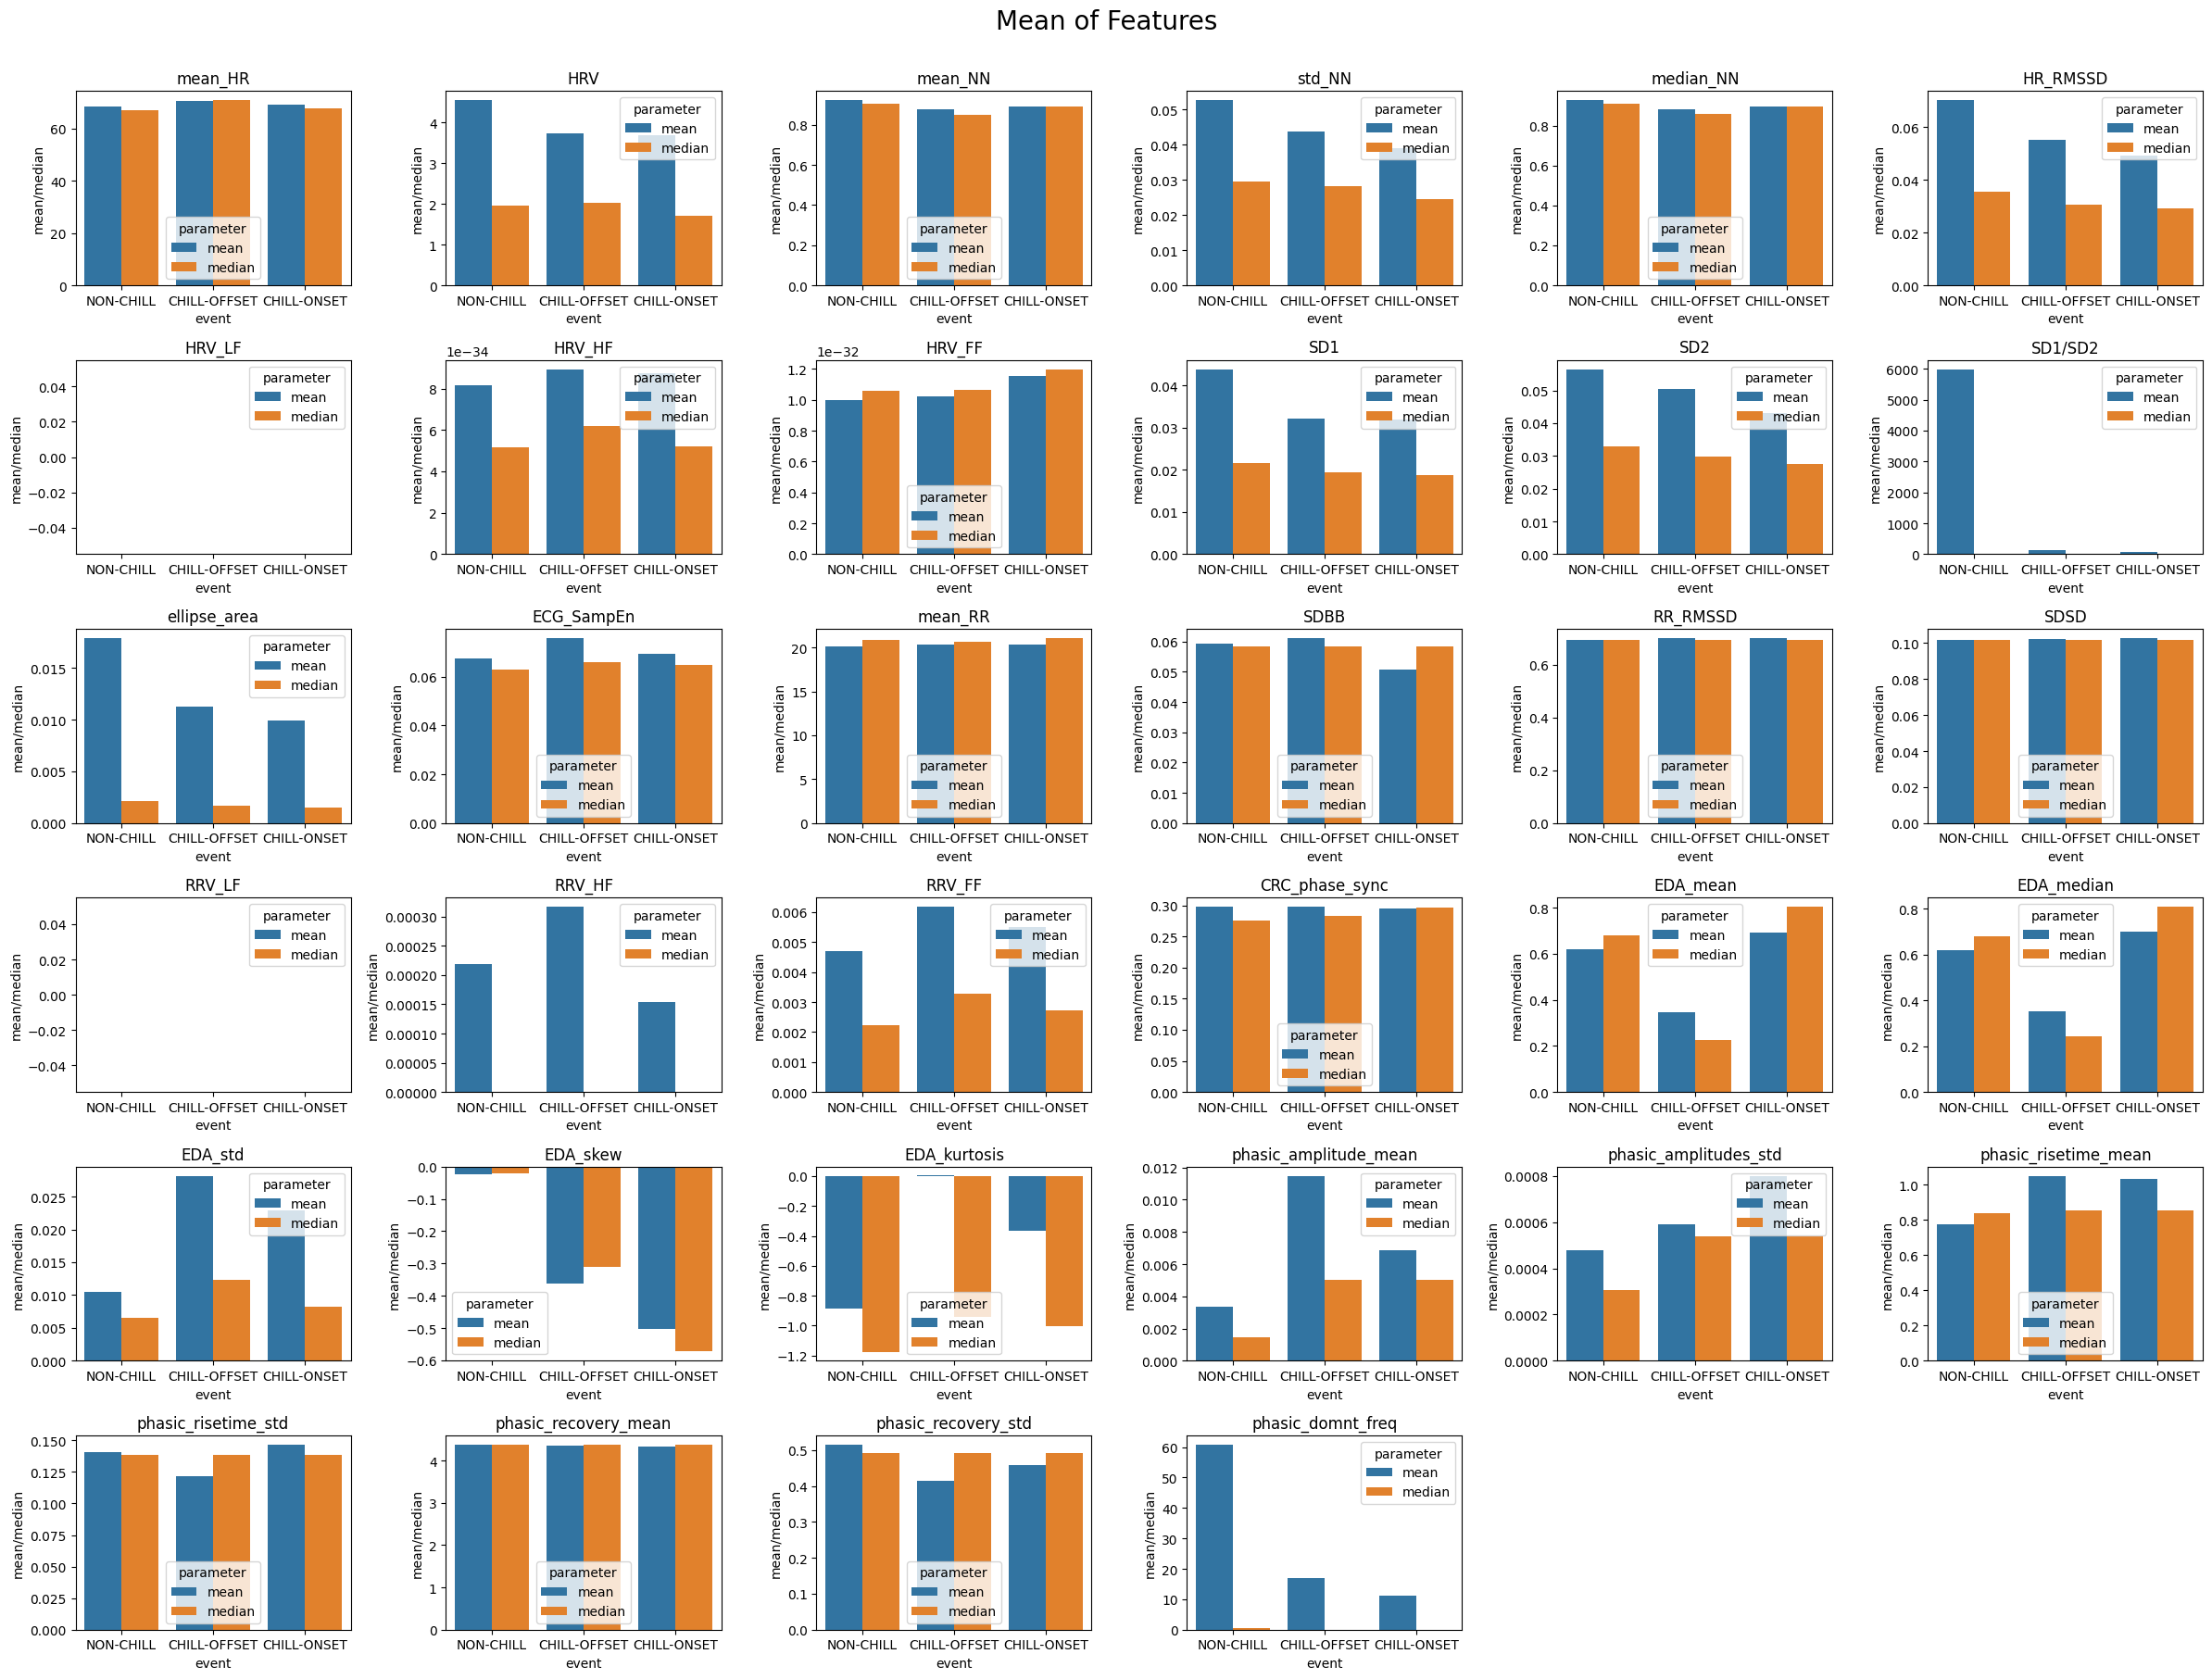

In [ ]:
nrows = ncols = math.ceil(math.sqrt(non_chills_stats.shape[1]))
fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))

xs = non_chills_stats.columns
for x_idx, x in enumerate(xs):

  # y_ = [stats.loc["mean"][x] for stats in [non_chills_stats, pre_chills_stats, post_chills_stats, chills_stats]]
  # y_ += [stats.loc["50%"][x] for stats in [non_chills_stats, pre_chills_stats, post_chills_stats, chills_stats]]
  # label = ["NON-CHILL", "PRE-CHILL", "POST-CHILL", "CHILL"]*2
  # stat = ["mean"]*4 + ["median"]*4

  y_ = [stats.loc["mean"][x] for stats in [non_chills_stats, chills_offset_stats, chills_onset_stats]]
  y_ += [stats.loc["50%"][x] for stats in [non_chills_stats, chills_offset_stats, chills_onset_stats]]
  label = ["NON-CHILL", "CHILL-OFFSET", "CHILL-ONSET"]*3
  stat = ["mean"]*3 + ["median"]*3

  df = pd.DataFrame([y_, label, stat], ["mean/median", "event", "parameter"]).T
  sns.barplot(df, y="mean/median", x="event", hue="parameter", ax=ax_.flatten()[x_idx])
  ax_.flatten()[x_idx].set_title(x)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Mean of Features", y=1.005, fontsize=20)
fig.tight_layout()

fig.savefig("plots/features_mean_median.png")

<ipython-input-99-b692402ffbb8>:10: RuntimeWarning: invalid value encountered in scalar divide
  y_ = [stats.loc["std"][x]/stats.loc["mean"][x] for stats in [non_chills_stats, chills_offset_stats, chills_onset_stats]]


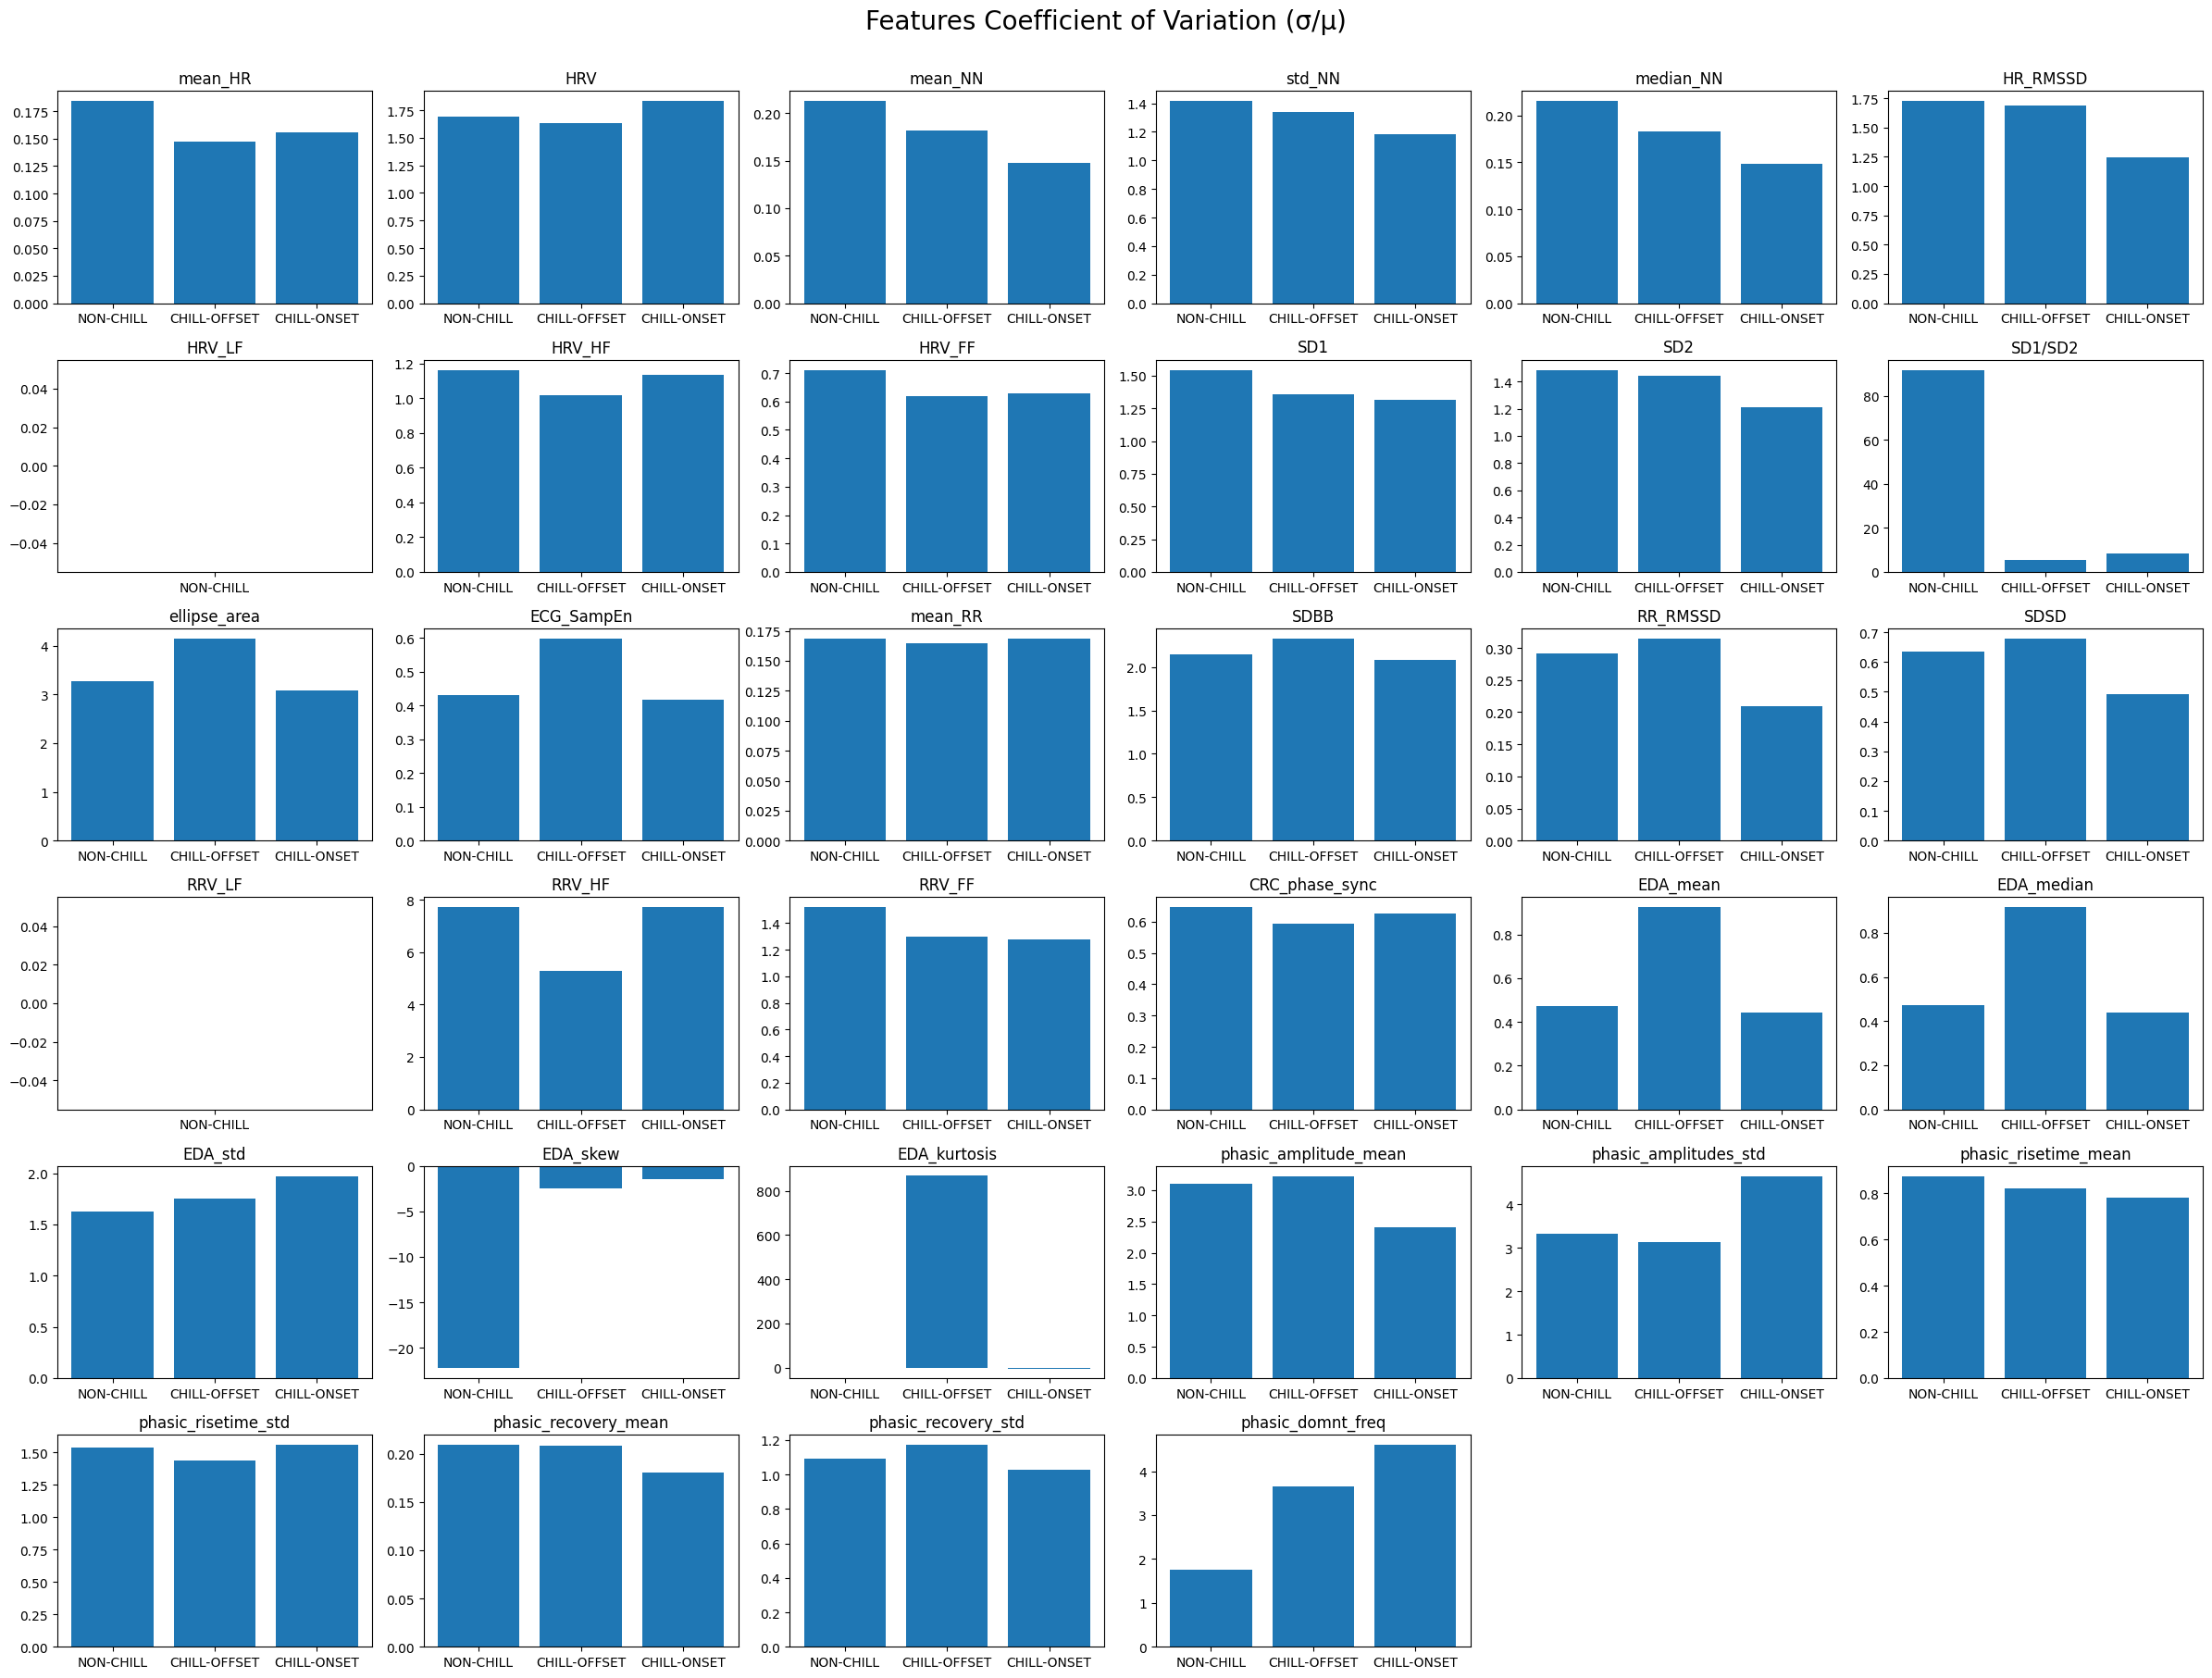

In [ ]:
nrows = ncols = math.ceil(math.sqrt(non_chills_stats.shape[1]))
fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))

xs = non_chills_stats.columns
for x_idx, x in enumerate(xs):
  # x_ = ["NON-CHILL", "PRE-CHILL", "POST-CHILL", "CHILL"]
  # y_ = [stats.loc["std"][x]/stats.loc["mean"][x] for stats in [non_chills_stats, pre_chills_stats,  post_chills_stats, chills_stats]]

  x_ = ["NON-CHILL", "CHILL-OFFSET", "CHILL-ONSET"]
  y_ = [stats.loc["std"][x]/stats.loc["mean"][x] for stats in [non_chills_stats, chills_offset_stats, chills_onset_stats]]

  ax_.flatten()[x_idx].bar(x_, y_)
  ax_.flatten()[x_idx].set_title(x)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Features Coefficient of Variation (σ/μ)", y=1.005, fontsize=20)
fig.tight_layout()

fig.savefig("plots/coefficient_of_variation.png")

#### View Distributions

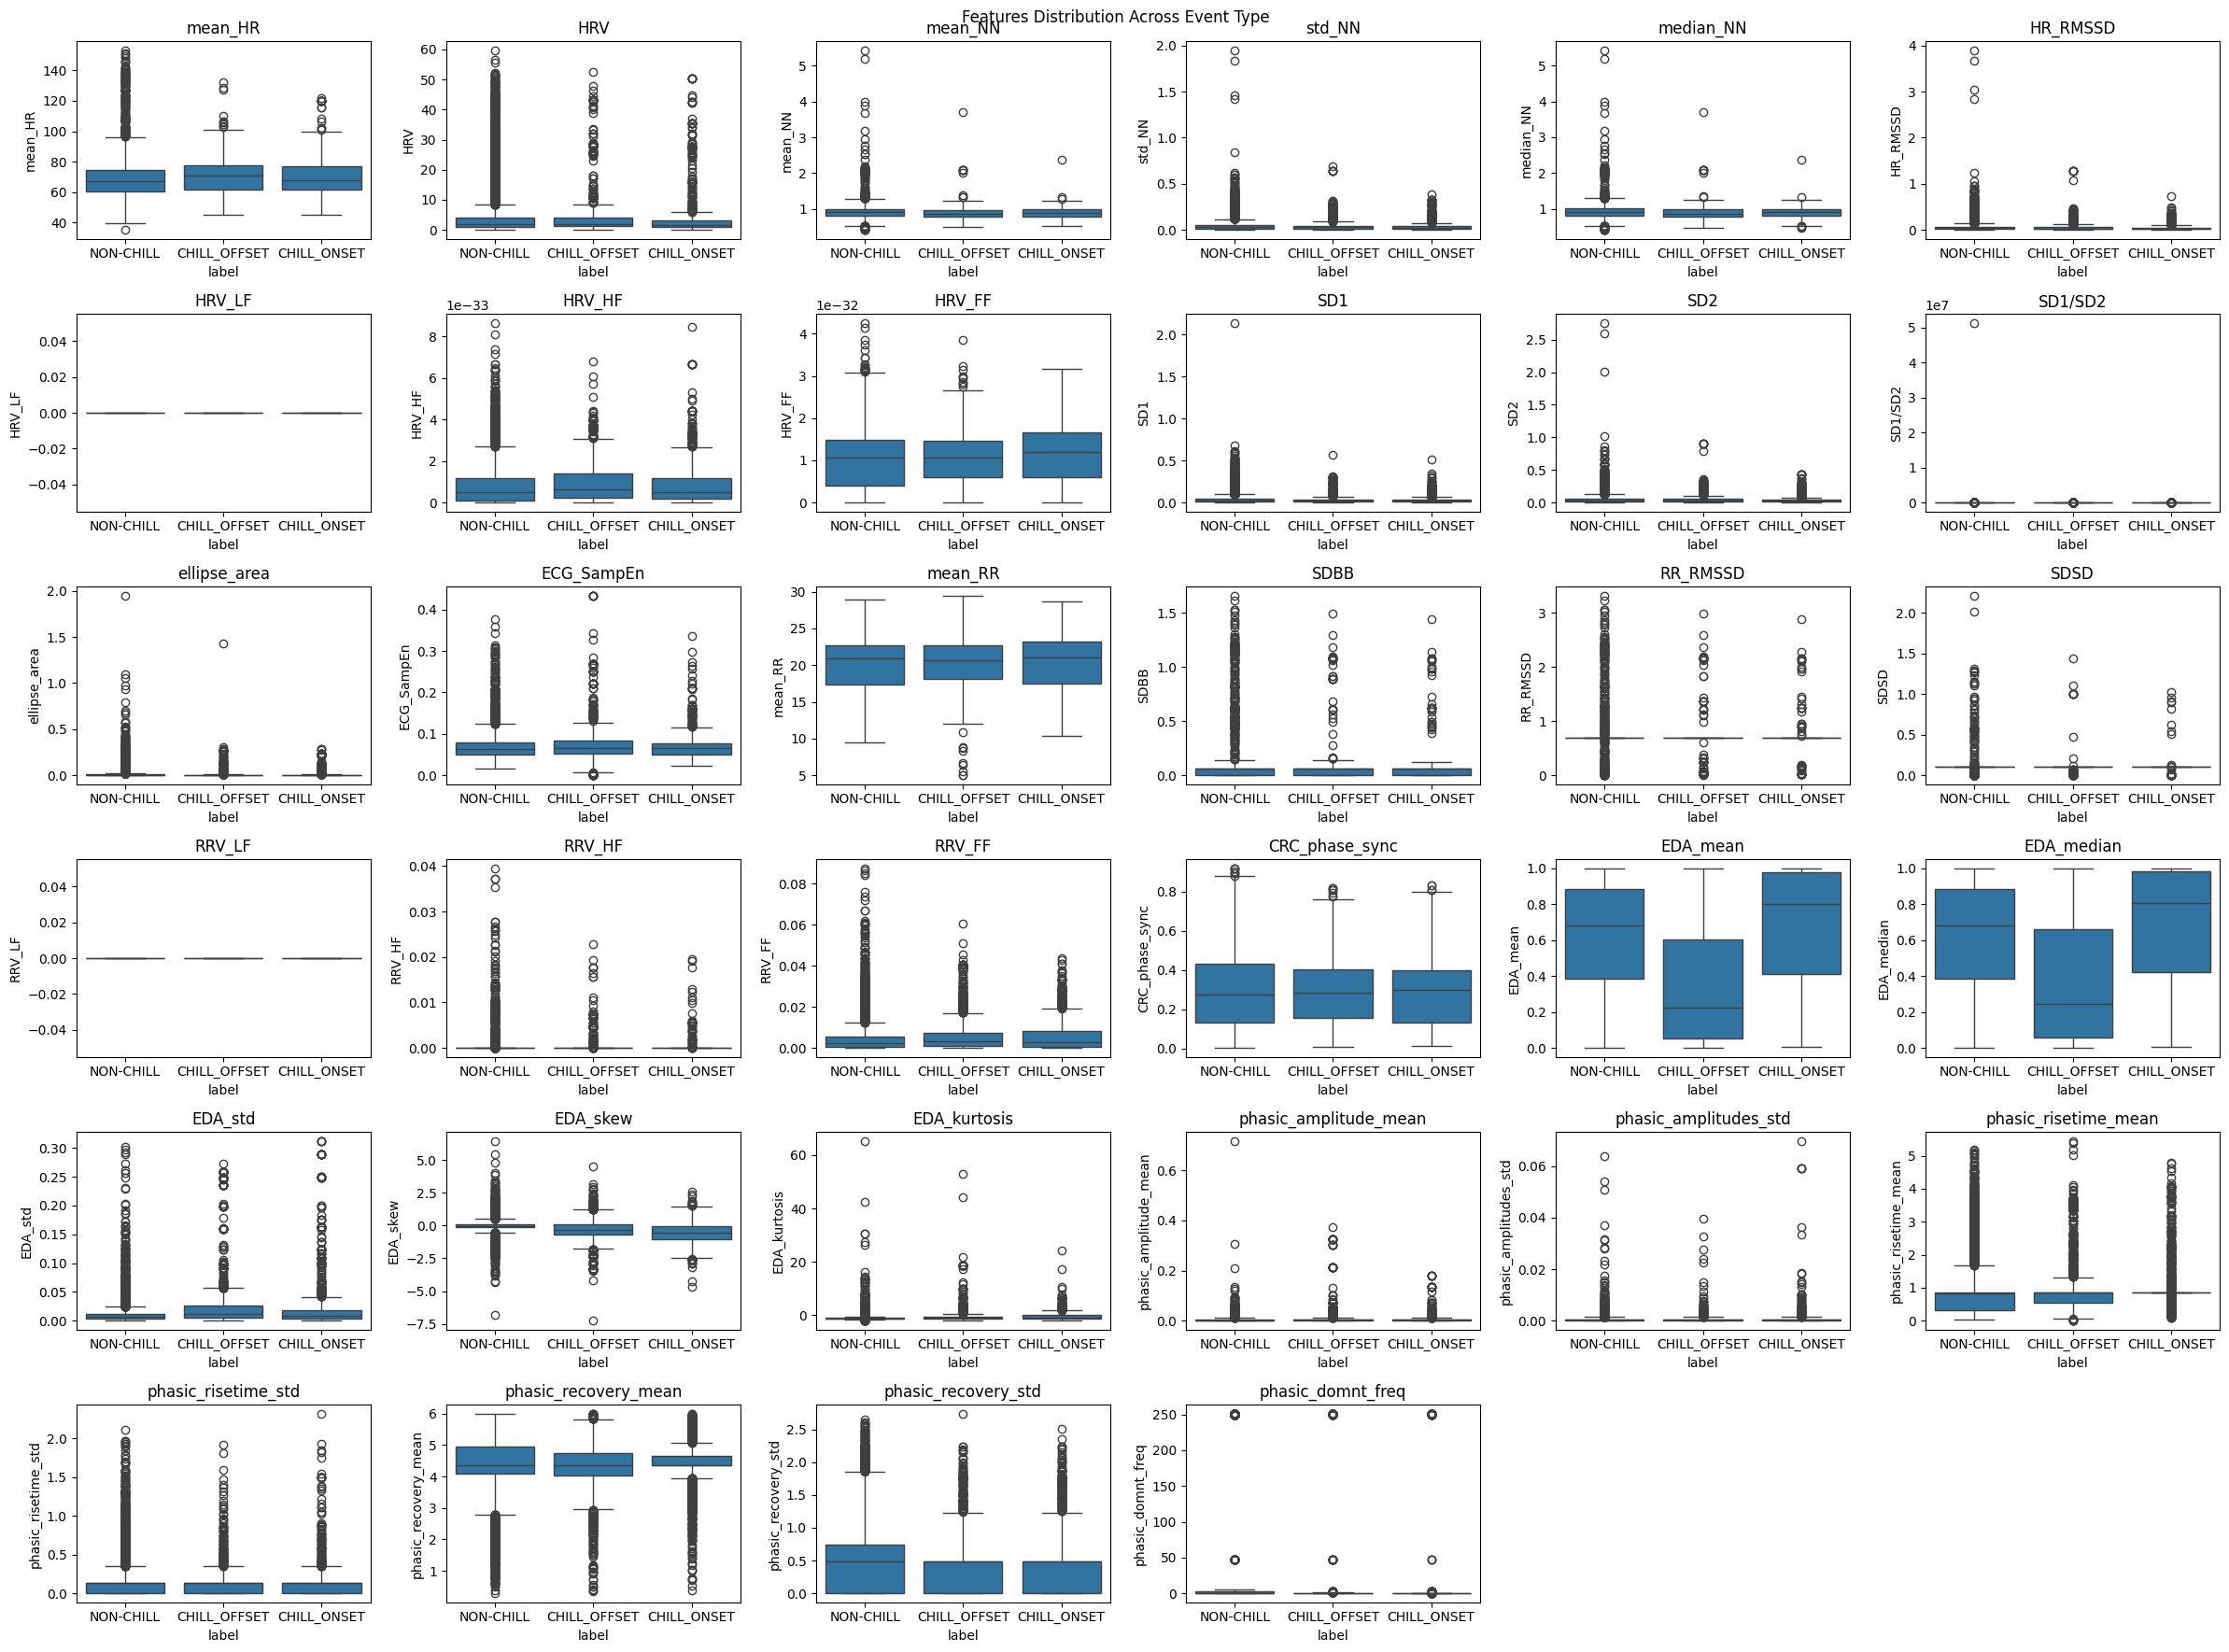

In [ ]:
features["label"] = all_df["label"]
no_x = features.shape[1] - 1

nrows = math.ceil(math.sqrt(no_x))
ncols = nrows

fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))

xs = features.columns[:-1]
for x_idx, x in enumerate(xs):
  sns.boxplot(features, x="label", y=x, ax=ax_.flatten()[x_idx])
  ax_.flatten()[x_idx].set_title(x)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Features Distribution Across Event Type")
fig.tight_layout()
fig.savefig(f"plots/features_dist_box.png")

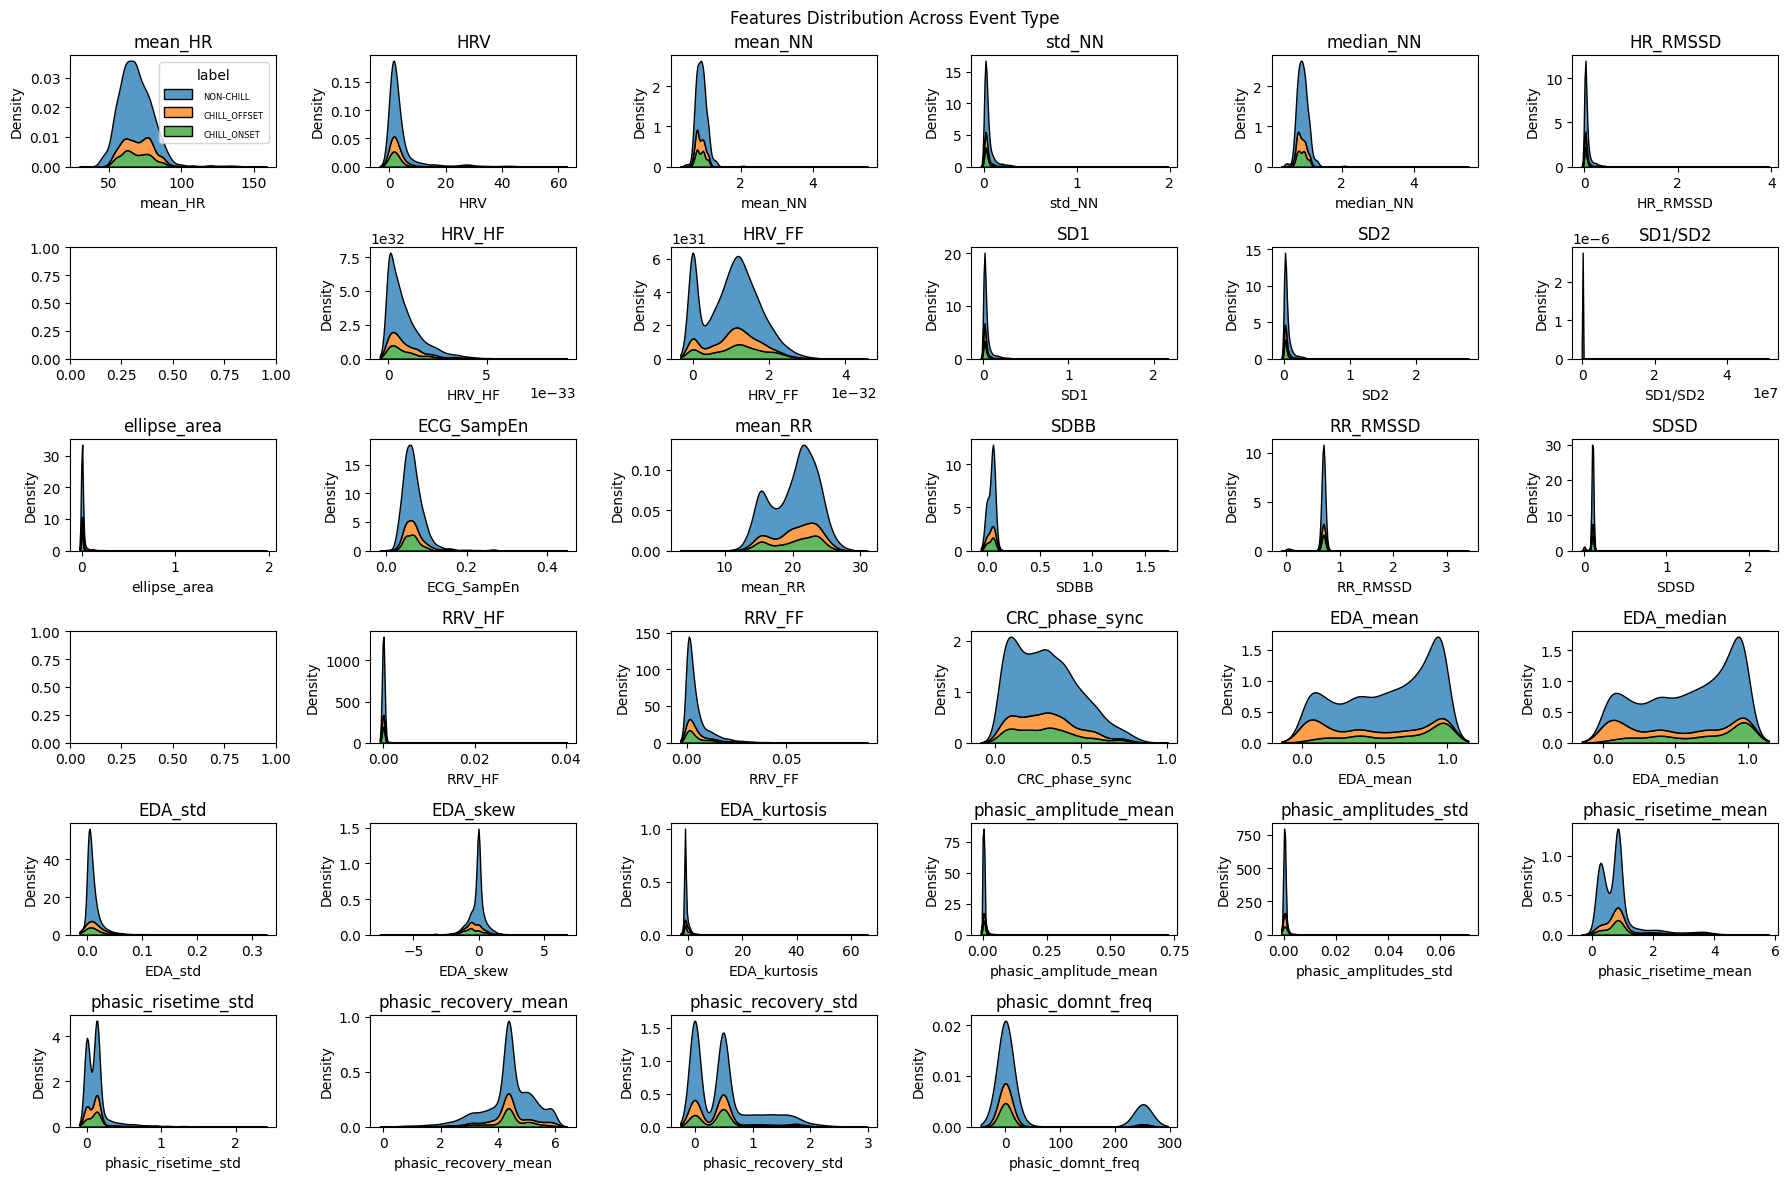

In [ ]:
features["label"] = all_df["label"]
no_x = features.shape[1] - 1

nrows = math.ceil(math.sqrt(no_x))
ncols = nrows

fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2))

xs = features.columns[:-1]
for x_idx, x in enumerate(xs):
  try:
    sns.kdeplot(features, x=x, hue="label", ax=ax_.flatten()[x_idx], multiple="stack")
    ax_.flatten()[x_idx].set_title(x)

    # Set legend size
    if x_idx != 0:
      ax_.flatten()[x_idx].legend_.remove()
    else:
      legend = ax_.flatten()[x_idx].legend_
      if legend:
          for text in legend.get_texts():
              text.set_fontsize(6)  # Adjust font size
  except:
    pass

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Features Distribution Across Event Type")
fig.tight_layout()
fig.savefig(f"plots/features_dist_kde.png")

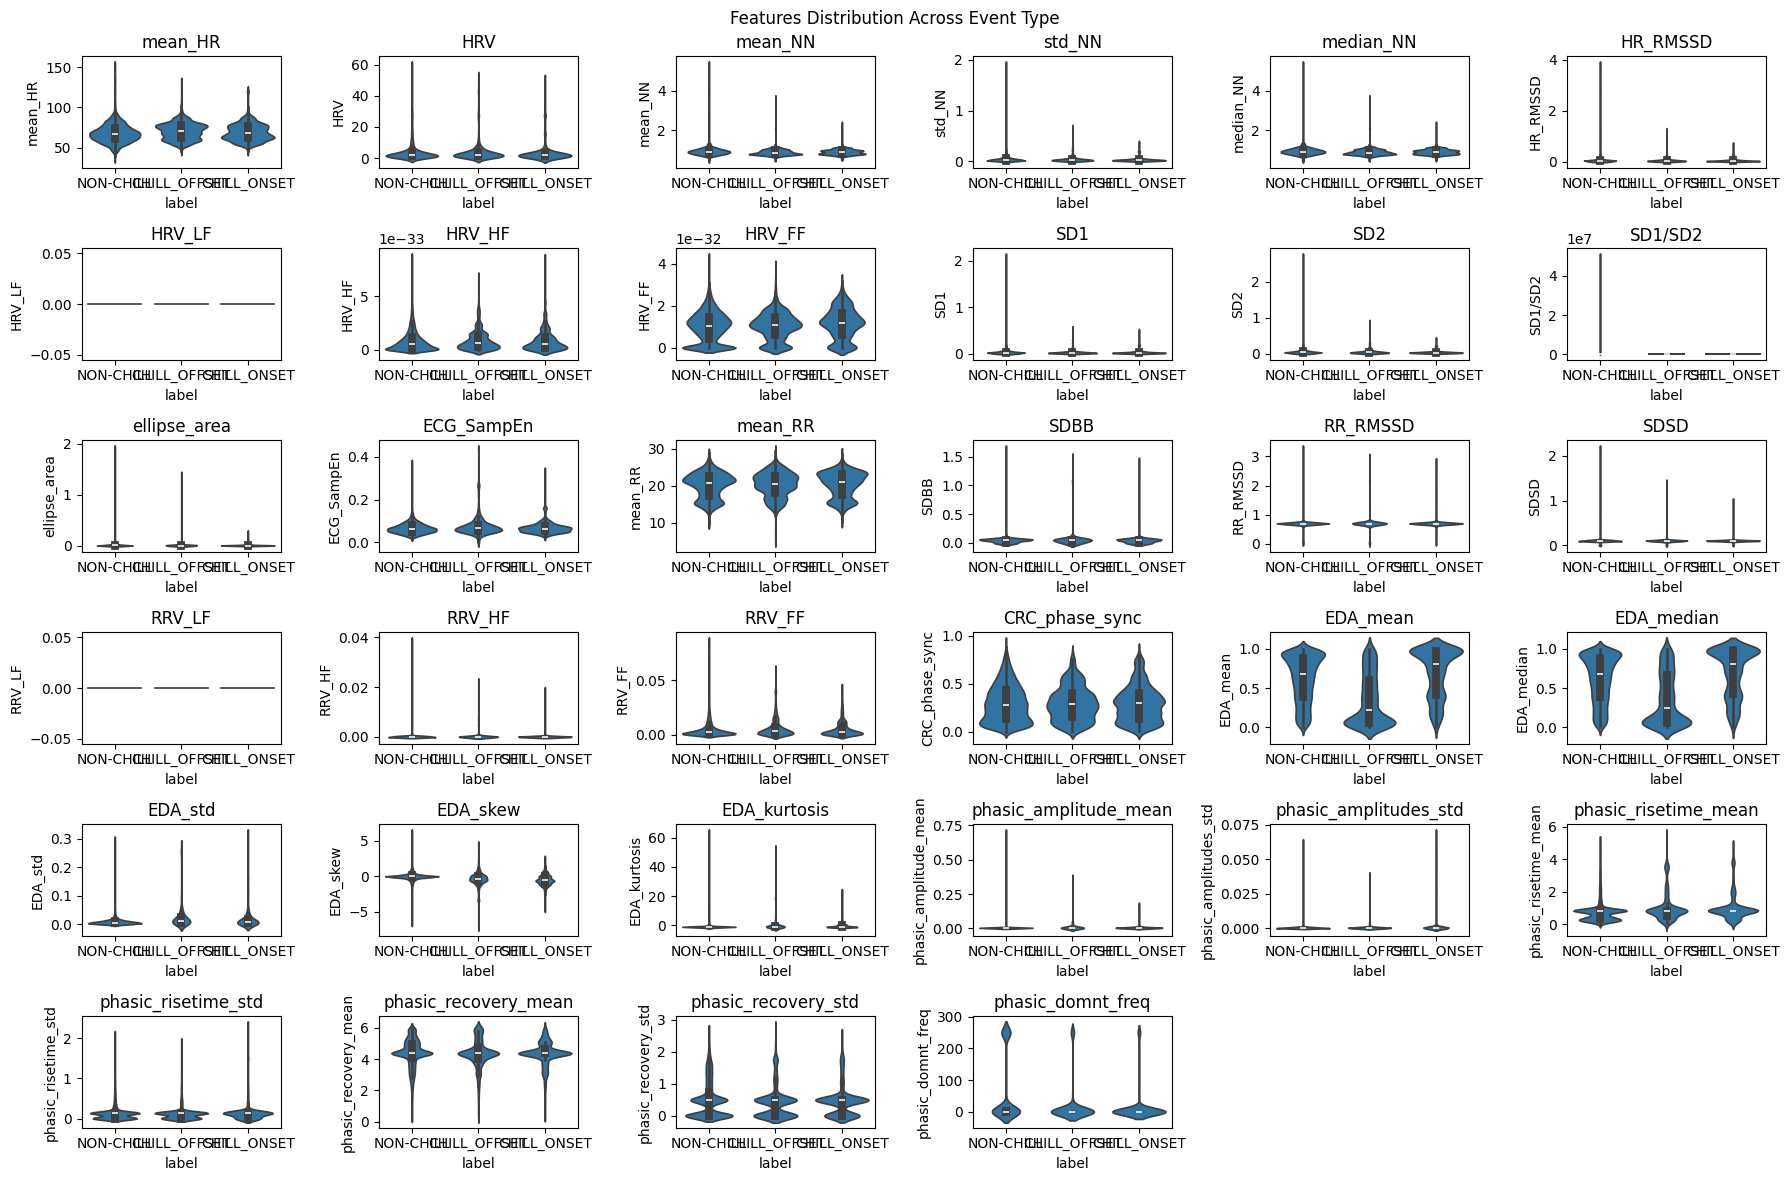

In [ ]:
features["label"] = all_df["label"]
no_x = features.shape[1] - 1

nrows = math.ceil(math.sqrt(no_x))
ncols = nrows

fig, ax_ = plt.subplots(nrows, ncols, figsize=(ncols*3, nrows*2))

xs = features.columns[:-1]
for x_idx, x in enumerate(xs):
  sns.violinplot(features, x="label", y=x, ax=ax_.flatten()[x_idx])
  ax_.flatten()[x_idx].set_title(x)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

for idx in range(x_idx, len(ax_.flatten())):
  ax_.flatten()[idx].set_visible(False)

fig.suptitle("Features Distribution Across Event Type")
fig.tight_layout()
fig.savefig(f"plots/features_violin_box.png")

#### Selecting Relevant Features - F test

In [ ]:
# @title F-Test & Mutual Information

# X = features.drop("label", axis=1)
X = features
y = all_df["label"]

f_scores, p_values = f_classif(X, y)
mi_scores = mutual_info_classif(X,y)
rejected, corrected_pvals = multipletests(p_values, alpha=0.01, method='fdr_bh')[:-2]

importance_df = pd.DataFrame({
    "feature": X.columns,
    "f_score": f_scores,
    "p_value": p_values,
    "mi_score": mi_scores,
    "FDR_rejected": rejected,
    "FDR_corrected_pval": corrected_pvals
})

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 6 18] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


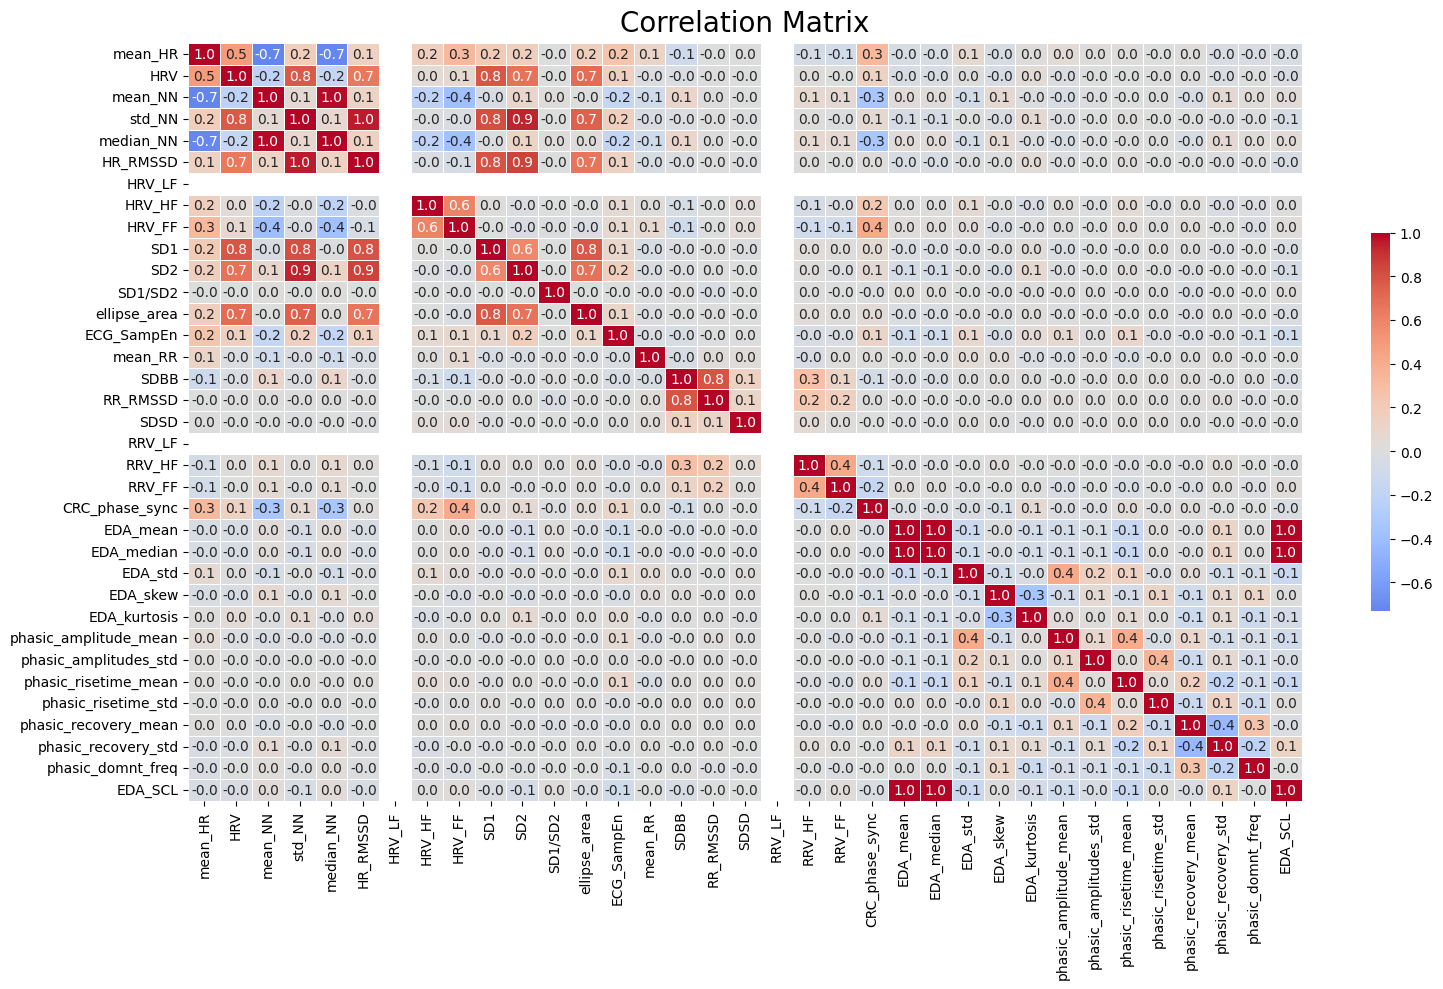

In [ ]:
# @title Correlation Matrix

# corr_matx = features.drop(["label"], axis=1, inplace=False).corr()
corr_matx = features.corr()

plt.figure(figsize=(16, 10))

mask = np.triu(np.ones_like(corr_matx, dtype=bool))
# sns.heatmap(corr_matx, mask=mask, annot=True, cmap="coolwarm", center=0, fmt=".1f", linewidths=0.5, cbar_kws={"shrink": 0.5})
sns.heatmap(corr_matx, annot=True, cmap="coolwarm", center=0, fmt=".1f", linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title("Correlation Matrix", y=1.005, fontsize=20)
plt.tight_layout()
plt.savefig("plots/relevant_features_corr.png")


Highly correlated features (|r| >= 0.35):
mean_HR -- HRV: 0.489
mean_HR -- mean_NN: -0.733
mean_HR -- median_NN: -0.721
HRV -- mean_HR: 0.489
HRV -- std_NN: 0.763
HRV -- HR_RMSSD: 0.651
HRV -- SD1: 0.783
HRV -- SD2: 0.674
HRV -- ellipse_area: 0.699
mean_NN -- mean_HR: -0.733
mean_NN -- median_NN: 0.985
mean_NN -- HRV_FF: -0.388
std_NN -- HRV: 0.763
std_NN -- HR_RMSSD: 0.958
std_NN -- SD1: 0.813
std_NN -- SD2: 0.935
std_NN -- ellipse_area: 0.746
median_NN -- mean_HR: -0.721
median_NN -- mean_NN: 0.985
median_NN -- HRV_FF: -0.378
HR_RMSSD -- HRV: 0.651
HR_RMSSD -- std_NN: 0.958
HR_RMSSD -- SD1: 0.803
HR_RMSSD -- SD2: 0.853
HR_RMSSD -- ellipse_area: 0.663
HRV_HF -- HRV_FF: 0.603
HRV_FF -- mean_NN: -0.388
HRV_FF -- median_NN: -0.378
HRV_FF -- HRV_HF: 0.603
HRV_FF -- CRC_phase_sync: 0.409
SD1 -- HRV: 0.783
SD1 -- std_NN: 0.813
SD1 -- HR_RMSSD: 0.803
SD1 -- SD2: 0.581
SD1 -- ellipse_area: 0.773
SD2 -- HRV: 0.674
SD2 -- std_NN: 0.935
SD2 -- HR_RMSSD: 0.853
SD2 -- SD1: 0.581
SD2 -- ellipse_ar

<ipython-input-17-a70a2f549f65>:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


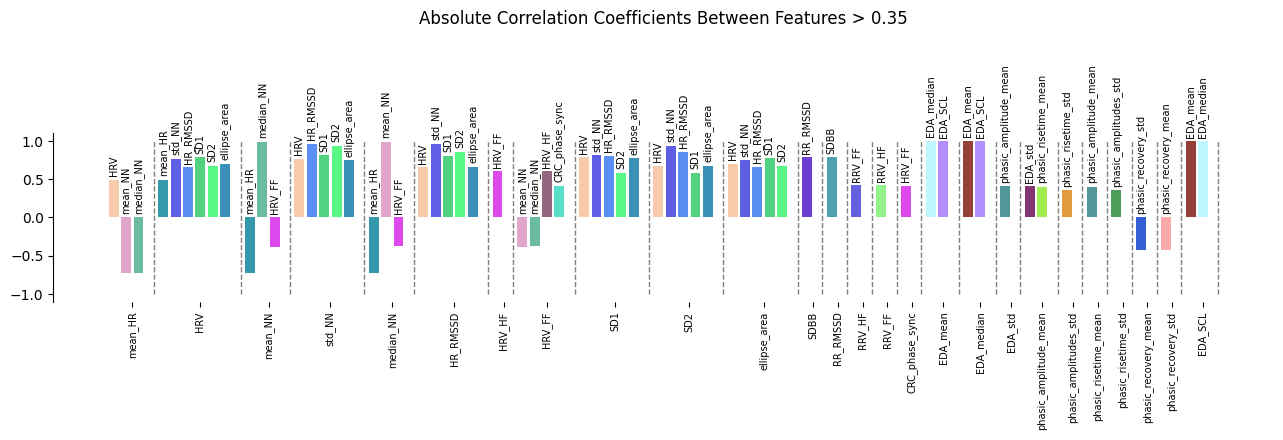

In [ ]:
# @title Best Correlations

threshold = 0.35
correlated_variables = []
high_corr = np.where(np.abs(corr_matx) >= threshold)
high_corr = [[x, y]
              for x, y in zip(*high_corr) if x != y]
if high_corr:
    print(f"\nHighly correlated features (|r| >= {threshold}):")
    for x, y in high_corr:
        print(f"{corr_matx.index[x]} -- {corr_matx.columns[y]}: {corr_matx.iloc[x, y]:.3f}")
        correlated_variables.append(corr_matx.index[x])
        correlated_variables.append(corr_matx.index[y])

correlated_variables = list(set(correlated_variables))


num_columns = len(corr_matx.columns)
# cmap = get_cmap('tab20b', num_columns)  # Use a colormap with enough distinct colors
# color_map = {col: cmap(i) for i, col in enumerate(corr_matx.columns)}
color_map = {col: (random.random(), random.random(), random.random(), 0.8) for i, col in enumerate(corr_matx.columns)}

high_corr = np.array(high_corr)

xs, ys = high_corr[:,0], high_corr[:,1]
figure = plt.figure(figsize=(threshold*45, threshold*25/4))
xticks, xlabels = [], []
legend_handles = []

x_pos = 0
for x_idx, x in enumerate(np.unique(xs)):

  y_idx = np.where(xs==x)[0]
  corrs = np.array(corr_matx.iloc[x, ys[y_idx]])

  # legend_handles += [plt.Line2D([0], [0], color=color_map[corr_matx.columns[y_]],
  #                               lw=4, label=corr_matx.columns[y_]) for y_ in ys[y_idx]]

  plt.bar([x_pos + i for i in range(len(corrs))], corrs, color=[color_map[corr_matx.columns[y_]] for y_ in ys[y_idx]])

  for x_, y_, y_id in zip([x_pos + i for i in range(len(corrs))], corrs, ys[y_idx]):
    y_  = (y_ + 0.05) if y_ > 0 else (0 + 0.05)
    plt.text(x_, y_, corr_matx.columns[y_id], rotation=90, ha='center', va='bottom', fontsize=7)

  plt.vlines(x_pos + len(corrs) + 0.25, -1, 1, "gray", linestyle='--', linewidth=1)
  xticks.append((x_pos + (x_pos + len(corrs))) / 2)
  xlabels.append(corr_matx.columns[x])
  x_pos += len(corrs) + 1

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(xticks, xlabels, fontsize=7, rotation=90)
# plt.ylim(-1.05, 1.05)
plt.title(f"Absolute Correlation Coefficients Between Features > {threshold}", y=1.6)
plt.tight_layout()
plt.savefig("plots/highest_correlations", bbox_inches="tight")

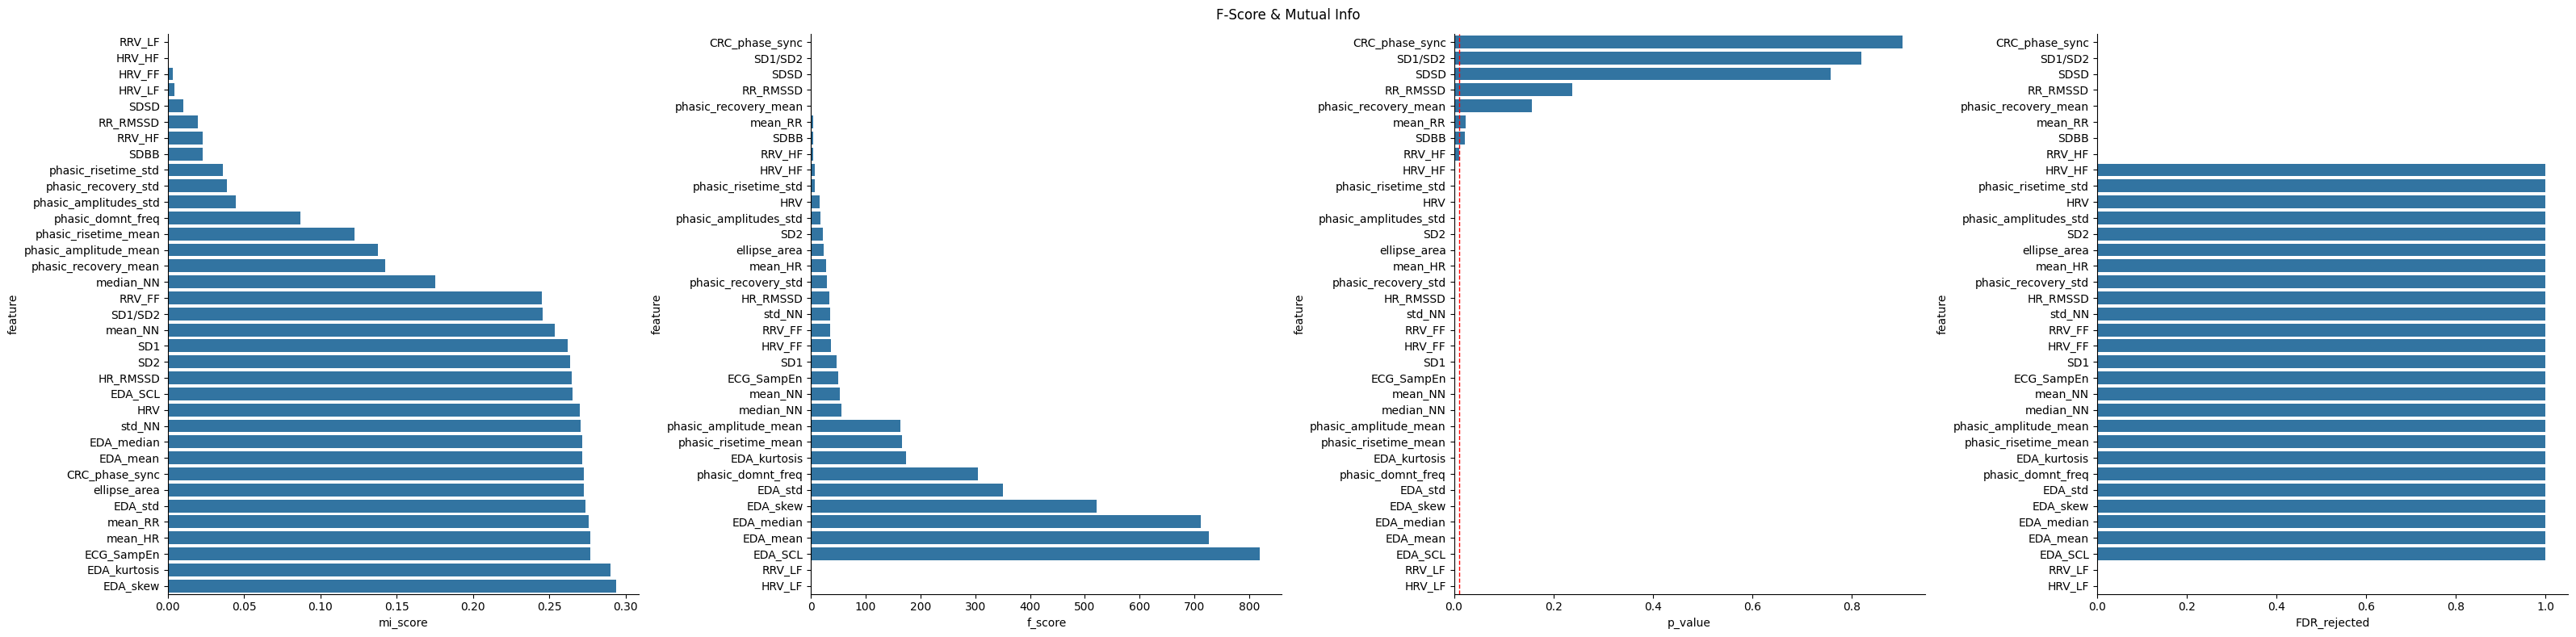

In [ ]:
# @title F-Test & Mutual Information Plot

fig, ax_ = plt.subplots(1, 4, figsize=(32, 8))

importance_df = importance_df.sort_values(by="mi_score", ascending=True)
sns.barplot(data=importance_df, x="mi_score", y="feature", ax=ax_[0])

importance_df = importance_df.sort_values(by="p_value", ascending=False)
# importance_df = importance_df.sort_values(by="f_score", ascending=False)
sns.barplot(data=importance_df, x="f_score", y="feature", ax=ax_[1])
# importance_df = importance_df.sort_values(by="p_value", ascending=False)
sns.barplot(data=importance_df, x="p_value", y="feature", ax=ax_[2])
sns.barplot(data=importance_df, x="FDR_rejected", y="feature", ax=ax_[3])

ax_[2].axvline(x=0.01, color='red', linestyle='--', linewidth=1)

for ax in ax_:
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

fig.suptitle("F-Score & Mutual Info")
plt.tight_layout()

fig.savefig("plots/feature_importance.png")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


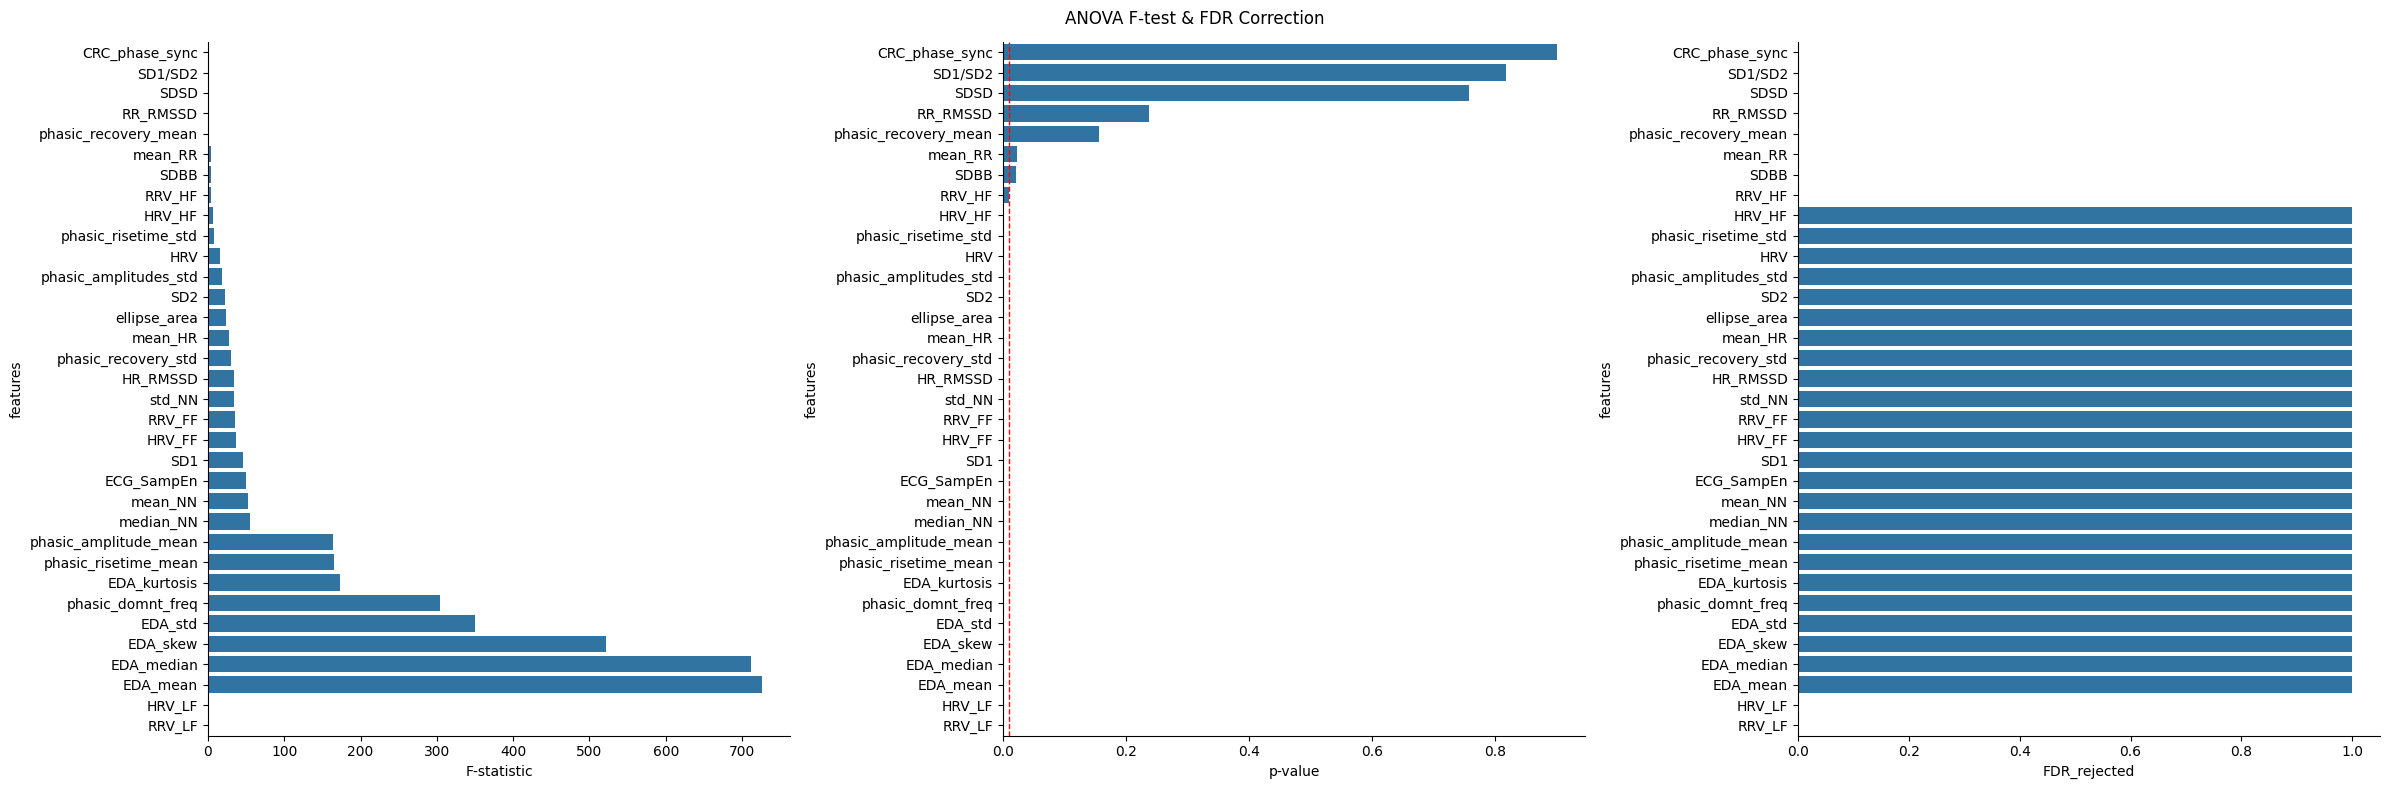

In [ ]:
# ## # @title ANOVA

from scipy.stats import f_oneway

anova_result = {}

for feature in all_df.columns[3:-1]:
    groups = [all_df[all_df['label']==cls][feature] for cls in all_df['label'].unique()]
    f_value, p_value = f_oneway(*groups)
    anova_result[feature] = {'F-statistic': f_value, 'p-value': p_value}

anova_result = pd.DataFrame(anova_result).T
rejected, corrected_pvals = multipletests(anova_result['p-value'], alpha=0.01, method='fdr_bh')[:-2]
anova_result['FDR_rejected'] = rejected
anova_result['FDR_corrected_pval'] = corrected_pvals
p_val_sorted_anova = anova_result.sort_values(by='p-value', ascending=False)
p_val_sorted_anova["features"] = p_val_sorted_anova.index

fig, ax_ = plt.subplots(1, 3, figsize=(24,8))

sns.barplot(data=p_val_sorted_anova, x='F-statistic', y='features', ax=ax_[0])
sns.barplot(data=p_val_sorted_anova, x='p-value', y='features', ax=ax_[1])
sns.barplot(data=p_val_sorted_anova, x='FDR_rejected', y='features', ax=ax_[2])

ax_[1].axvline(x=0.01, color='red', linestyle='--', linewidth=1)

for ax in ax_:
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

fig.suptitle("ANOVA F-test & FDR Correction")
fig.tight_layout()

fig.savefig("plots/feature_importance_anova.png")

#### Dimesionality Reduction On Most Correlatied & Statistically Significant Features

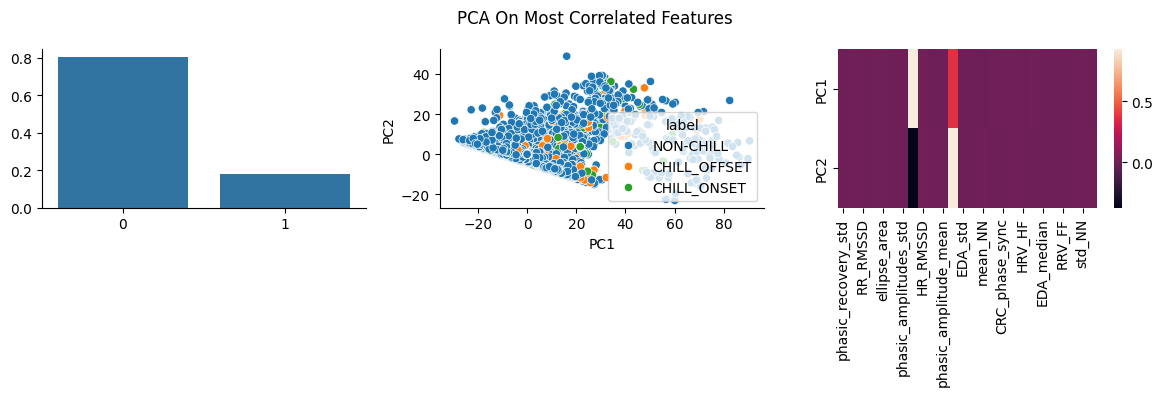

In [ ]:
# @title Most Correlated Features

len(correlated_variables), len(all_df.columns)-2

features = all_df[correlated_variables+["label"]]

from sklearn.decomposition import PCA
pca_ = PCA(2)

latent_space = pca_.fit_transform(features[features.columns[:-1]])
latent_space = pd.DataFrame(latent_space, columns=[f"PC{i+1}" for i in range(latent_space.shape[1])])
latent_space["label"] = features["label"]

fig, ax_ = plt.subplots(1, 3, figsize=(12,4))

sns.barplot(pca_.explained_variance_ratio_, ax=ax_[0])
sns.scatterplot(data=latent_space, x="PC1", y="PC2", hue="label", ax=ax_[1])
vars_ = pd.DataFrame(pca_.components_, columns=features.columns[:-1], index=[f"PC{i+1}" for i in range(latent_space.shape[1]-1)])
sns.heatmap(vars_, ax=ax_[2])

for ax in ax_:
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

fig.suptitle("PCA On Most Correlated Features")
fig.tight_layout()

fig.savefig("plots/PCA_best_correlated_features.png", bbox_inches="tight")

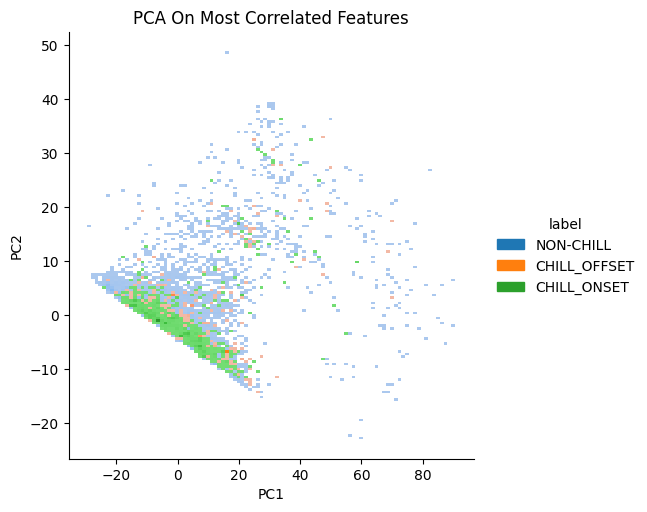

In [ ]:
sns.displot(latent_space, x="PC1", y="PC2", hue="label")
plt.title("PCA On Most Correlated Features")
plt.savefig("plots/PCA_MCF_dist.png", bbox_inches="tight")

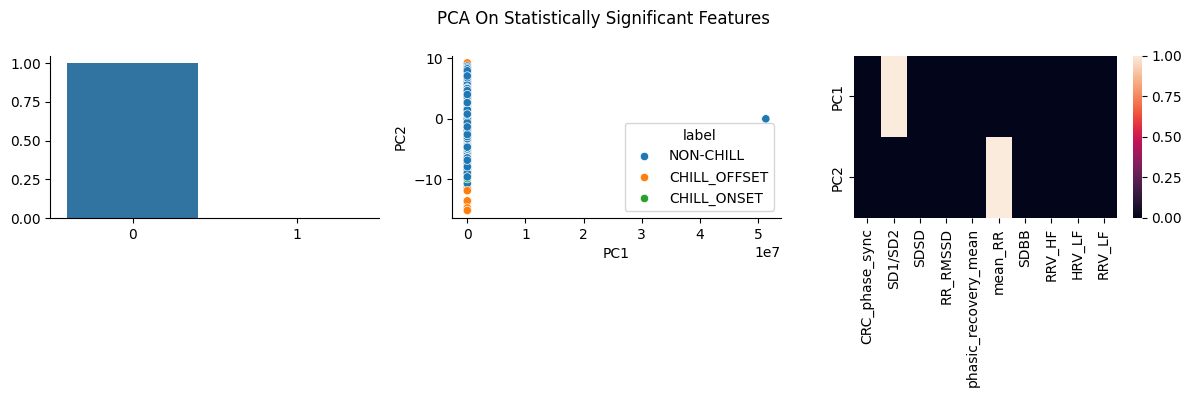

In [ ]:
# @title Statistically Significant Features

SSFs = ["CRC_phase_sync", "SD1/SD2", "SDSD", "RR_RMSSD", "phasic_recovery_mean", "mean_RR", "SDBB", "RRV_HF", "HRV_LF", "RRV_LF"]

features = all_df[SSFs+["label"]]

from sklearn.decomposition import PCA
pca_ = PCA(2)

latent_space = pca_.fit_transform(features[features.columns[:-1]])
latent_space = pd.DataFrame(latent_space, columns=[f"PC{i+1}" for i in range(latent_space.shape[1])])
latent_space["label"] = features["label"]

fig, ax_ = plt.subplots(1, 3, figsize=(12,4))

sns.barplot(pca_.explained_variance_ratio_, ax=ax_[0])
sns.scatterplot(data=latent_space, x="PC1", y="PC2", hue="label", ax=ax_[1])
vars_ = pd.DataFrame(pca_.components_, columns=features.columns[:-1], index=[f"PC{i+1}" for i in range(latent_space.shape[1]-1)])
sns.heatmap(vars_, ax=ax_[2])

for ax in ax_:
  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

fig.suptitle("PCA On Statistically Significant Features")
fig.tight_layout()

fig.savefig("plots/PCA_SSF_features.png", bbox_inches="tight")

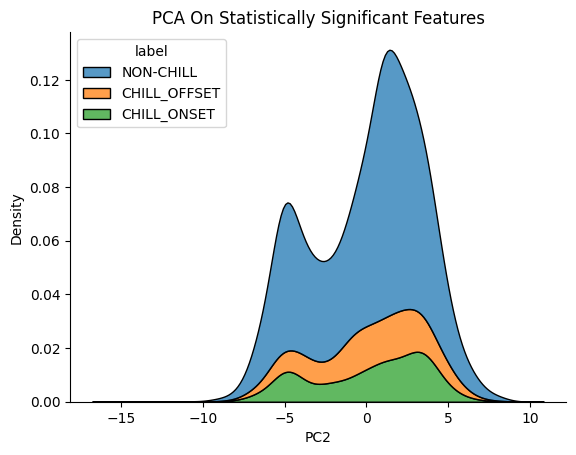

In [ ]:
# latent_space

sns.kdeplot(latent_space, x="PC2", hue="label", multiple="stack")
plt.title("PCA On Statistically Significant Features")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig("plots/PCA_SSF_dist.png", bbox_inches="tight")

# Download Artifacts

In [ ]:
# @title Download Plots

import shutil
from google.colab import files

plots = shutil.make_archive("plots", "zip", "plots")

files.download("plots.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


# Run Scripts

In [ ]:
! python feature_extraction.py
# clear_output(wait=True)
# time.sleep(0.5)
print("Features Extraction Script Run Complete")

---------------------------------------------------------------SUBJECT: 5002 | 0/115 ---------------------------------------------------------------------------------------------------------------------------------
5002 post_rest non-chills data extracted
---------------------------------------------------------------SUBJECT: 5006 | 1/115 ---------------------------------------------------------------------------------------------------------------------------------
5006 pre_rest non-chills data extracted
5006 post_rest non-chills data extracted
---------------------------------------------------------------SUBJECT: 5001 | 2/115 ---------------------------------------------------------------------------------------------------------------------------------
5001 pre_rest non-chills data extracted
5001 post_rest non-chills data extracted
---------------------------------------------------------------SUBJECT: 5007 | 3/115 -------------------------------------------------------------------